In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import matplotlib.dates as mdates
import seaborn as sns

/opt/homebrew/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#clean up data for
data = pd.read_csv('full_data.csv')
data = data.drop(columns="Unnamed: 0")
data['Date'] = pd.to_datetime(data['Date'])

btc = data.loc[data['Crypto']=='BTC']
btc = btc.sort_values(by='Date')
btc = btc.reset_index(drop=True)
btc = btc.drop(['Crypto'],axis=1)
btc = btc.set_index('Date')

eth = data.loc[data['Crypto']=='ETH']
eth = eth.sort_values(by='Date')
eth = eth.reset_index(drop=True)
eth = eth.drop(['Crypto'],axis=1)
eth = eth.set_index('Date')

ltc = data.loc[data['Crypto']=='LTC']
ltc = ltc.sort_values(by='Date')
ltc = ltc.reset_index(drop=True)
ltc = ltc.drop(['Crypto'],axis=1)
ltc = ltc.set_index('Date')

#training data
btc = btc.loc[btc.index<=datetime(2022,5,31)]
eth = eth.loc[eth.index<=datetime(2022,5,31)]
ltc = ltc.loc[ltc.index<=datetime(2022,5,31)]

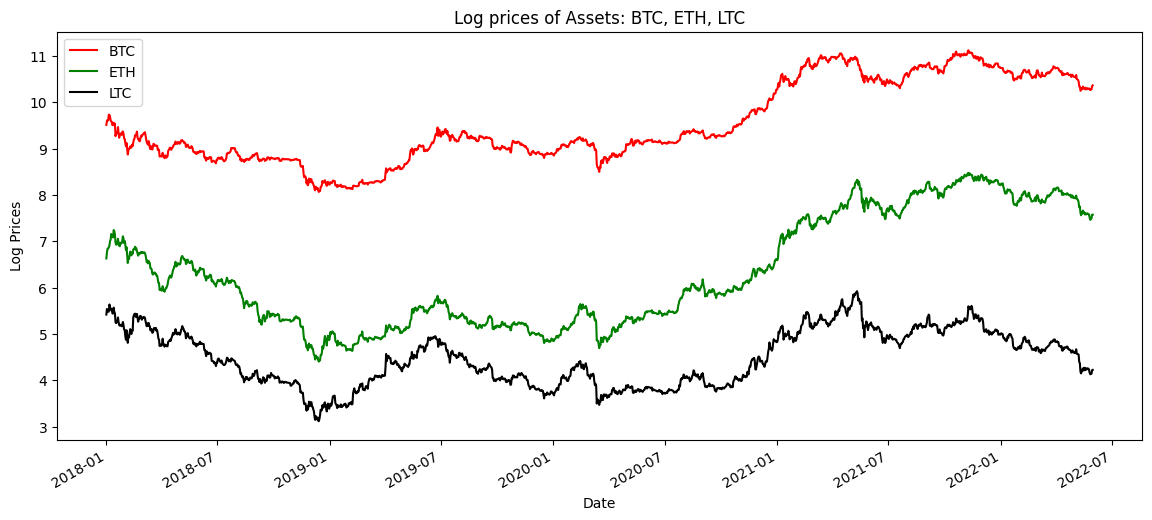

In [3]:
plt.figure(figsize=(14, 6))  # Width = 12 inches, Height = 6 inches
plt.plot(btc.index, np.log(btc['Close']), color = 'r', label='BTC')
plt.plot(eth.index, np.log(eth['Close']), color = 'g', label='ETH')
plt.plot(ltc.index, np.log(ltc['Close']), color = 'black', label='LTC')

plt.xlabel("Date")
plt.ylabel("Log Prices")
plt.gcf().autofmt_xdate()  # Rotation
plt.title("Log prices of Assets: BTC, ETH, LTC")
plt.legend()  # This will add the legend to the plot
plt.show()

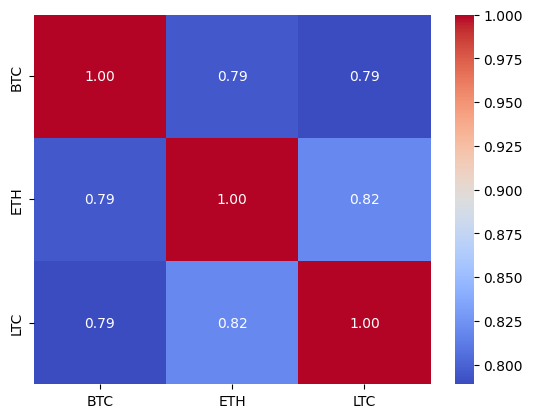

In [4]:
btc['pct_returns'] = btc['Close'].pct_change()
eth['pct_returns'] = eth['Close'].pct_change()
ltc['pct_returns'] = ltc['Close'].pct_change()

combined_df = pd.concat([btc['pct_returns'], eth['pct_returns'], ltc['pct_returns']], axis=1)
combined_df.columns = ['BTC', 'ETH', 'LTC']

# Calculate the correlation matrix
corr = combined_df.corr()
# Plotting the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# Analysis of the data

This is in line with (paper Tim) which shows cointegration would be a viable trading strategy given the high correlation between crypto currencies. Simillar analysis is done to above to prove this. We first split the data into training and testing. Training will be done from 1/1/2018 to 5/31/24. Testing from 6/1/24 to 5/31/24. Looking at the training data for all assets we see that they move in a simillar fashion. Further investigation shows high correlation between all three assets, thus justifying that a pairs trading strategy using cointegration is valid.

# Verify cointegration strategy is valid over 1 year data

In [5]:
from arch.unitroot import ADF
from arch.unitroot import KPSS
from arch.unitroot import PhillipsPerron
from sklearn.linear_model import LinearRegression
import arch

period = 60
combined_df_close = pd.concat([btc['Close'][:period], eth['Close'][:period], ltc['Close'][:period] ], axis=1)
combined_df_close.columns = ['BTC', 'ETH', 'LTC']
combined_df_close = combined_df_close.dropna()

#test for stationarity 1 differenced
tickers = combined_df_close.columns
tickers = combined_df_close.columns
for i in tickers:
  print(f'ADF {i}: {ADF(combined_df_close[i].diff().dropna()).pvalue}')
  print(f'PP {i}: {PhillipsPerron(combined_df_close[i].diff().dropna()).pvalue}')
  print(f'KPSS {i}: {KPSS(combined_df_close[i].diff().dropna()).pvalue}')

X = combined_df_close.drop("BTC", axis=1)
y = combined_df_close['BTC']
lin_model = LinearRegression()
lin_model.fit(X, y)

ADF BTC: 7.853084618328323e-14
PP BTC: 3.441089028647541e-14
KPSS BTC: 0.4377493187633337
ADF ETH: 3.136166721804409e-05
PP ETH: 2.63879573272991e-10
KPSS ETH: 0.3257375956079522
ADF LTC: 2.7188607416662e-13
PP LTC: 1.203289638414825e-13
KPSS LTC: 0.40357276300871964


LinearRegression()

In [6]:
coef = np.array([1] + list(-1*lin_model.coef_))
print("coefficients: ", coef)
print("intercept: ", lin_model.intercept_)

coefficients:  [  1.          -3.93805729 -46.60350811]
intercept:  -1967.235373880243


[]

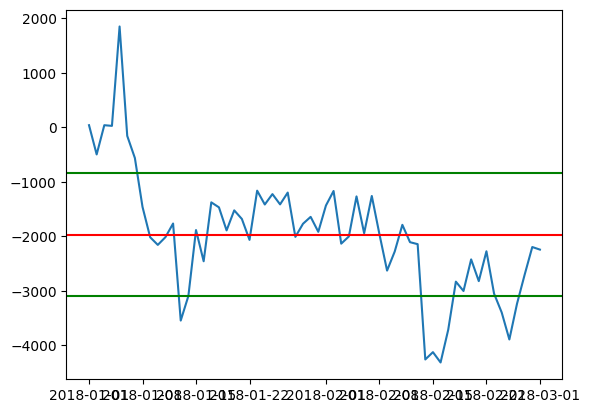

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
spread = combined_df_close
spread.columns = ['BTC', 'ETH', 'LTC']

spread['spread'] = spread.dot(coef)
plt.plot(spread.index, spread['spread'])
plt.axhline(y=spread['spread'].mean(), color='r', linestyle='-', label='Horizontal Line at E[spread]')
plt.axhline(y=spread['spread'].mean() + spread['spread'].std(), color='g', linestyle='-', label='UL-Bound')
plt.axhline(y=spread['spread'].mean() - spread['spread'].std(), color='g', linestyle='-')
plt.plot()


<Figure size 640x480 with 0 Axes>

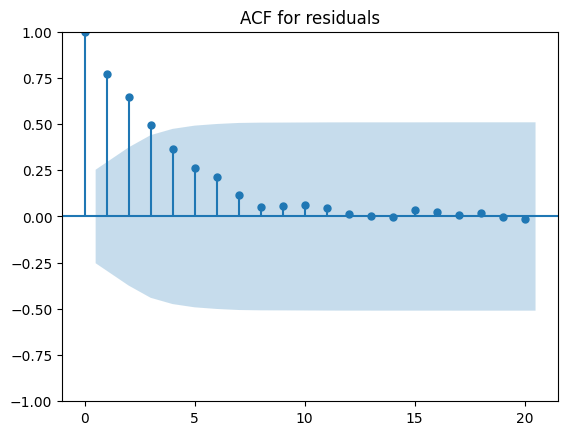

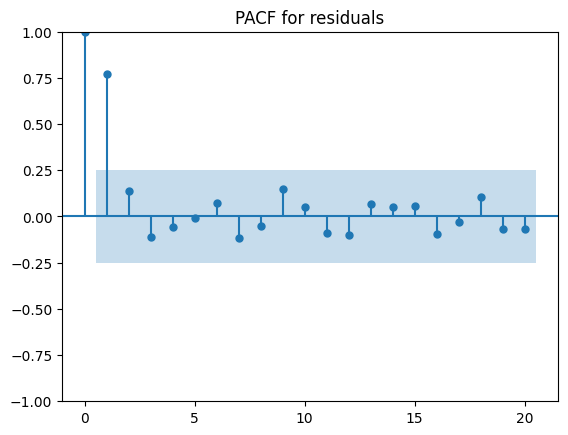

In [8]:
plt.figure()
plot_acf(spread['spread'], lags = 20, alpha = 0.05, title="ACF for residuals")
plot_pacf(spread['spread'], lags = 20, alpha = 0.05, title="PACF for residuals")
plt.show()

## Two-Step Method for Cointegration
We test for stationarity of the assets differenced once with ADF, Phillips Perron, and KPSS. We see that the Null hypothesis of non stationarity is rejected for all assets in regards to ADF, PP, while the null is accepted of stationarity for KPSS. We then apply the second step of fitting a linear regression model and finding the coefficients, representing in terms of residuals (verifying residuals are normal) and adjusting the equation in terms of the residuals which represent the spread below. Further more we plot the new cointegrated related spread to verify that mean-reversion is present. This demonstrates that pairs trading via cointegration may be profitable in the future.

# Strategies to use Moving Foreward

The claim is that the foreward looking benchmark portfolio can be beaten using  Machine Learning. Due to Machine Learning techniques needing extensive amounts of data our format for measurement will be as such.
- Training: 1/1/2018 to 5/31/2022
  - Parameter optmization
    - Walk Forward analysis to be done 5/31/2021 to 5/31/2022
  - ML model training
    - Walk Forward Analysis to find optimal days incorporated in Features matrix (both t+1, t+5)
- Test: 6/1/2022 to 5/31/2023
  - Comparison between benchmark and strategies will be conducted during this period.


# What are the three strategies?

### Strategy 1
- Standard pairs trading Cointegration
    - This is done such that trading parameters can be optimized for the other two strategies using ML. Because data is sparse.
      - sigma: which dictates upper and lower boundary signals for trading
      - History lookback: Formulation period of cointegrated relationship

### Strategies 2 and 3
- Standard pairs trading + ML forecast of t+1 and t+5 days ahead
  - This strategy adds a ML signal to the 1st strategy
  - New signal will require ML forecast t+n days out be in the direction of mean reversion


# Optimizing using Walk Forward Analysis

Methodology of the walk forward analysis:
- Timeframe: 1/1/2018 to 5/20/2022

Example for Sigma: \
Available sigma values from [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4]
are backtested in the training period with the objective being maximizing "Total Net Profit". From there the sigma value which maximizes the objective is backtested over the testing period. That testing period becomes the next training period which all of the sigma values are backtested again with the same objective of maximizing "Total Net Profit". The process iterates untill we arrive at 5/20/2022.

This same methodology is done with "history lookback" window as well (days of formulation). Incremented by 10 from 40 days to 180 days, data was sparse overall which was the reason to stop it at around 6 months.

In [9]:
df_sigma = pd.read_csv('sigma_WF.csv')
df_sigma = df_sigma.drop('Unnamed: 0', axis=1)
df_sigma

train_start   train_end  test_start    test_end  sigma_val  Total Net Profit
0  2018-01-01  2018-07-20  2018-07-20  2019-02-05       1.75         -997.1910
1  2018-07-20  2019-02-05  2019-02-05  2019-08-24       3.50        -3266.0605
2  2019-02-05  2019-08-24  2019-08-24  2020-03-11       4.00         1599.4123
3  2019-08-24  2020-03-11  2020-03-11  2020-09-27       0.75          704.7131
4  2020-03-11  2020-09-27  2020-09-27  2021-04-15       1.75        17281.4283
5  2020-09-27  2021-04-15  2021-04-15  2021-11-01       1.50        19473.2736
6  2021-04-15  2021-11-01  2021-11-01  2022-05-20       1.00         4141.3286

Text(0.5, 1.0, 'Walk Forward Analysis Sigma')

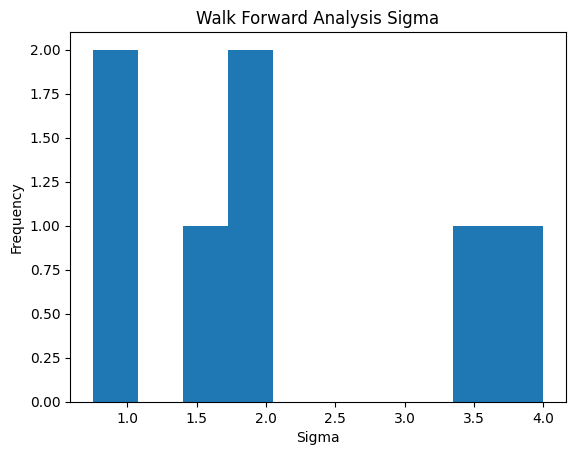

In [10]:
plt.hist(df_sigma['sigma_val'])
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.title('Walk Forward Analysis Sigma')

In [12]:
df_lookback = pd.read_csv('history_lookback_wf.csv')
df_lookback = df_lookback.drop('Unnamed: 0', axis=1)
df_lookback

train_start   train_end  test_start    test_end  history_val  \
0  2018-01-01  2018-07-20  2018-07-20  2019-02-05           50   
1  2018-07-20  2019-02-05  2019-02-05  2019-08-24          180   
2  2019-02-05  2019-08-24  2019-08-24  2020-03-11           70   
3  2019-08-24  2020-03-11  2020-03-11  2020-09-27           60   
4  2020-03-11  2020-09-27  2020-09-27  2021-04-15           60   
5  2020-09-27  2021-04-15  2021-04-15  2021-11-01           60   
6  2021-04-15  2021-11-01  2021-11-01  2022-05-20           60   

   Total Net Profit  
0         -777.2357  
1         -738.5295  
2         1018.1906  
3         3008.9380  
4        32315.8608  
5        19473.2736  
6         5849.0507

Text(0.5, 1.0, 'Walk Forward Analysis Window of Formulation')

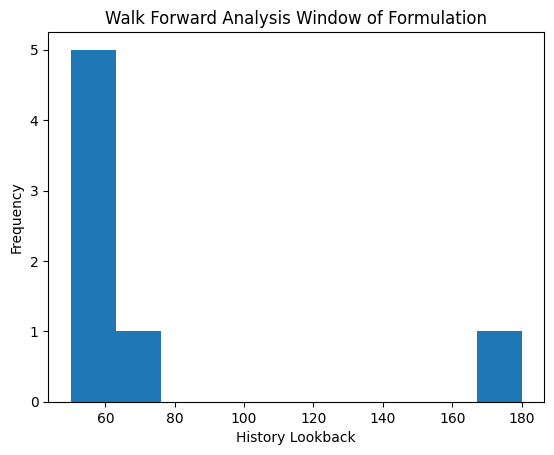

In [13]:
plt.hist(df_lookback['history_val'])
plt.xlabel('History Lookback')
plt.ylabel('Frequency')
plt.title('Walk Forward Analysis Window of Formulation')

Looking at the results from the Walk Forward Analysis we see conclusive results for History lookback of 60 days. The sigma value is more subjective, but by looking at the clustering around 1-2, a sigma value of 1.5 would be ideal. Tomasini Ch.3 suggest picking stable areas when choosing best parameters rather than the best net profit value, using this idea a sigma value of 1.5 was chosen.

# Designing the Machine Learning Model

Deep Neural Network models will be built to predict t+5, and t+1 days forecast. The forecast days were arrived at by qualitatively building many models and finding a relatively useful period to forecast ahead.

While building many models a few things were to note.
1. Learning curves were not entirely ideal.
  - This is due to the volatile nature of crypto-currencies. ML models were able to overfit well to the noise in the training set while falling short when it came to the validation set.
  - The first loss function was Mean Squared Error, and the learning curves did not do well even though the actual forecasting seemed reasonable (done on the test set).
  - A custom loss function of rolling percent change between y_pred and y_test was also applied. This solved the learning curve issues but the actual price forecasts were terrible. Often times it would defer to predicting the same value.
  - The learning curves did much better when optimizing models using keras-tuner.


2. Asset specific feature data resulted in better overall forecasting.
  - Meaning for forecasting BTC, feature data derived from BTC pricing were more relevant and made for better forecast than using a large feature matrix including ETH, and LTC.

## Finding the best Deep Neural Network using Keras-Tuner

```python
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
import keras_tuner as kt
import tensorflow as tf

def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=10, max_value=50, default=2)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    l2_reg = hp.Float("l2_reg", min_value=1e-4, max_value=100, sampling="log")
    optimizer = hp.Choice("optimizer", values=["Nadam", "Adam"])
    activation = hp.Choice("activation", values=["relu", "swish"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.0)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_train_scaled.shape[1:]))
    model.add(tf.keras.layers.Normalization())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss="mse", optimizer=optimizer,
                  metrics=["RootMeanSquaredError"])
    return model

random_search_tuner = kt.RandomSearch(
    build_model, objective="val_loss", max_trials=100, overwrite=True,
    directory="BTC", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train_scaled, y_train_btc, epochs=100,
                           validation_data=(X_val_scaled, y_val_btc))

top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
best_params = top3_params[0].values

print(f"Best hyperparameters: {best_params}")

```

Keras-Tuner was used to find the best DNN for each Asset Model With parameters resulting as follows: \

Models Forecasting t+5: \
BTC
- neurons: 15
- hidden_layers: 28
- activation: "swish"
- L2-regularization: 0.07815802051981617
- Learning rate: 0.003271730054012538
- optimizer: Nadam

LTC
- neurons: 9
- hidden_layers: 31
- activation: "swish"
- L2-regularization: 0.00020614917119897043
- Learning rate: 0.001047217795168058
- optimizer: Adam

ETH
- neurons: 73
- hidden_layers: 37
- activation: "swish"
- L2-regularization: 0.30538342190212675
- Learning rate: 0.00011631756169915276
- optimizer: Nadam


Models Forecasting t+1: \
BTC
- neurons: 35
- hidden_layers: 3
- activation: "relu"
- L2-regularization: 0.00025270483570026075
- Learning rate: 0.00012337256785879854
- optimizer: Adam

LTC
- neurons: 64
- hidden_layers: 27
- activation: "swish"
- L2-regularization: 0.00024026306425375133
- Learning rate: 0.00023700731349812458
- optimizer: Ndam

ETH
- neurons: 9
- hidden_layers: 18
- activation: "swish"
- L2-regularization: 29.789290262355248
- Learning rate: 0.0006951671294413008
- optimizer: Nadam


The same process was done for the custom loss function of rolling percent difference, and the results of that came out to be a constant price forecast. More work is neccessary in finding a proper loss function for crypto.

Below are the resulting graphs of the developed ML models using the parameters above.
We see the predictive power of the model with graphs showing the training, validation, and testing. Qualitatively looking, the predictive power looks reasonable, ETH looks quite spot on in all data sets. 

The learning curves are not ideal for BTC. However since they do not fluctuate so much through the epochs we see that chances of overfitting are not great. ETH has great learning curves with no sign of overfitting. LTC learning curves show that overfitting is occuring as the gap between training and validation narrow. 

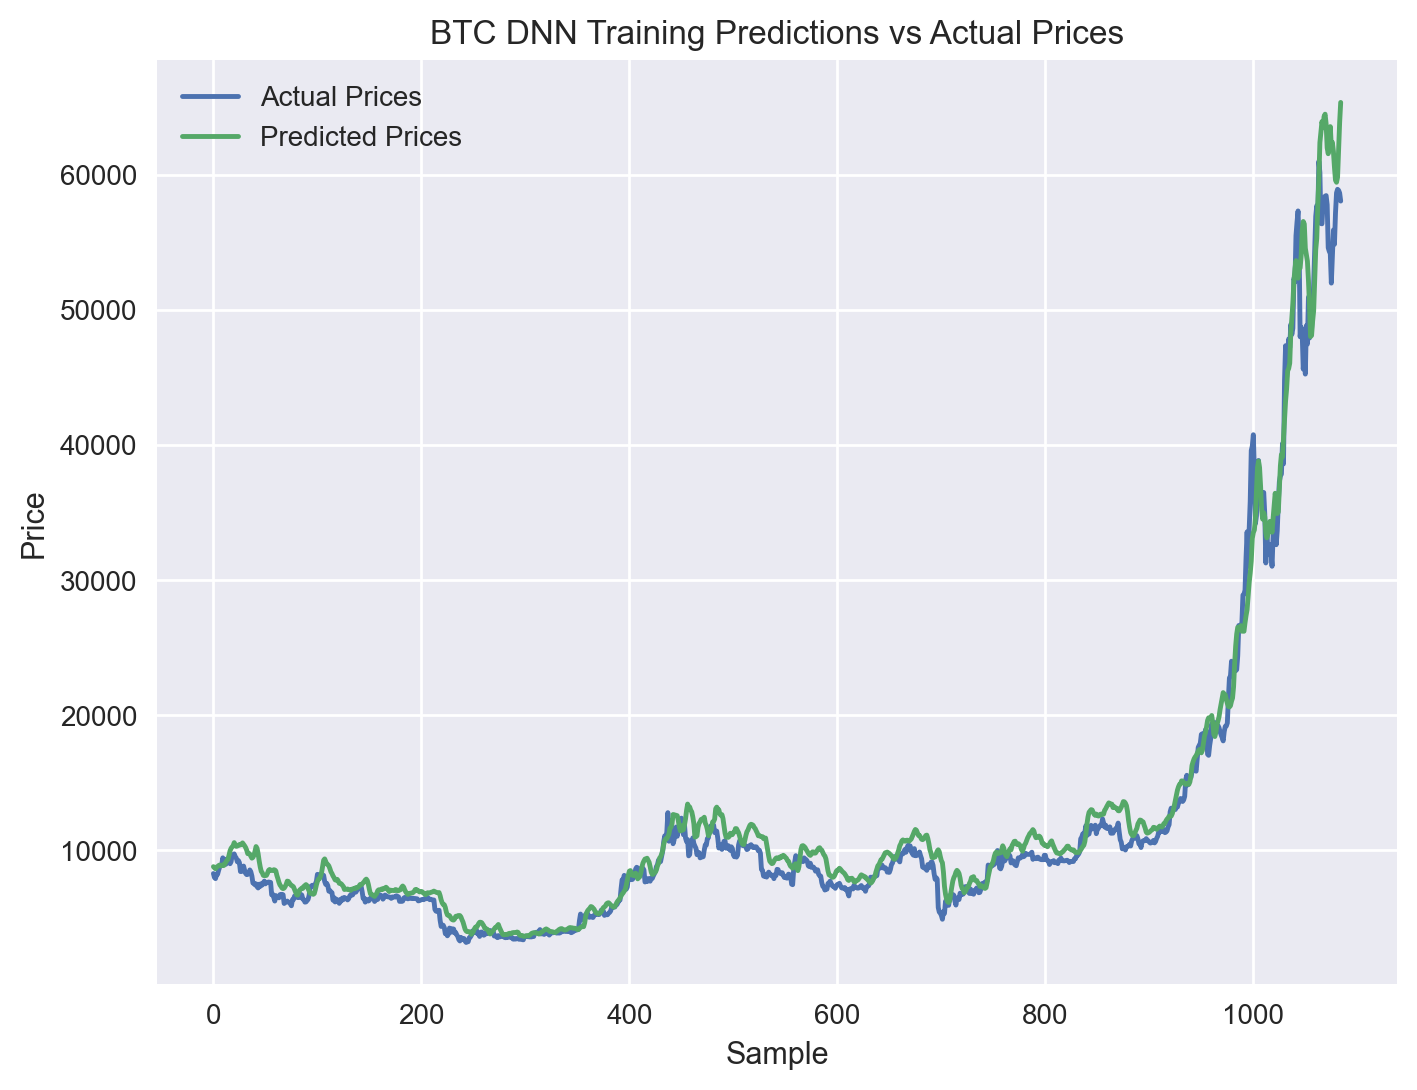

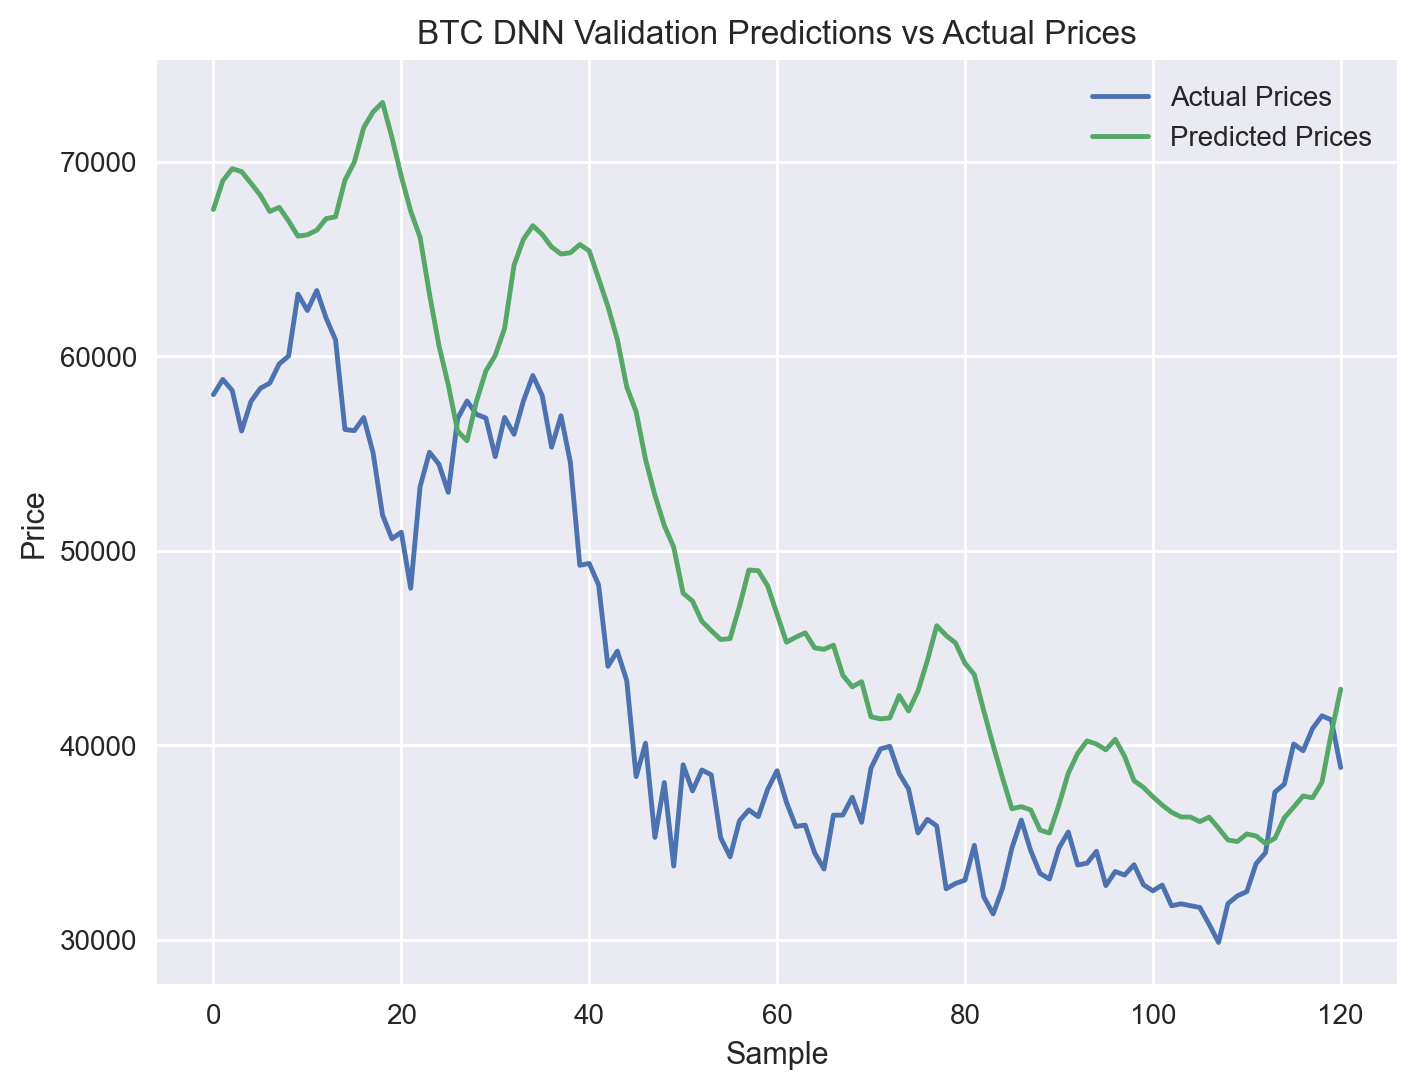

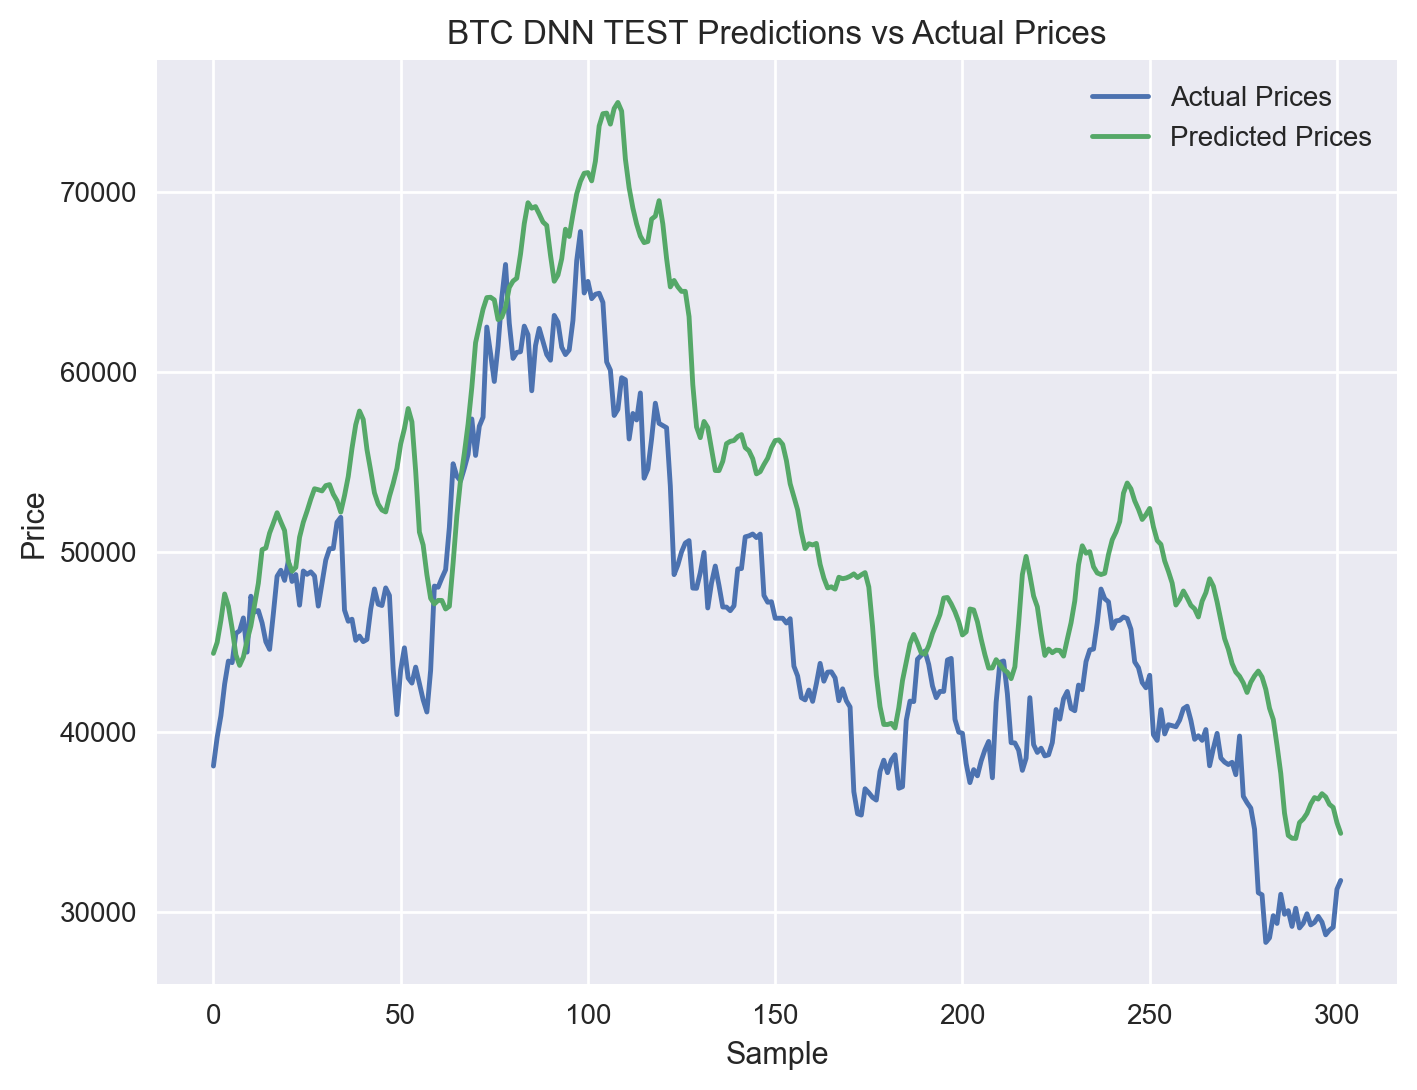

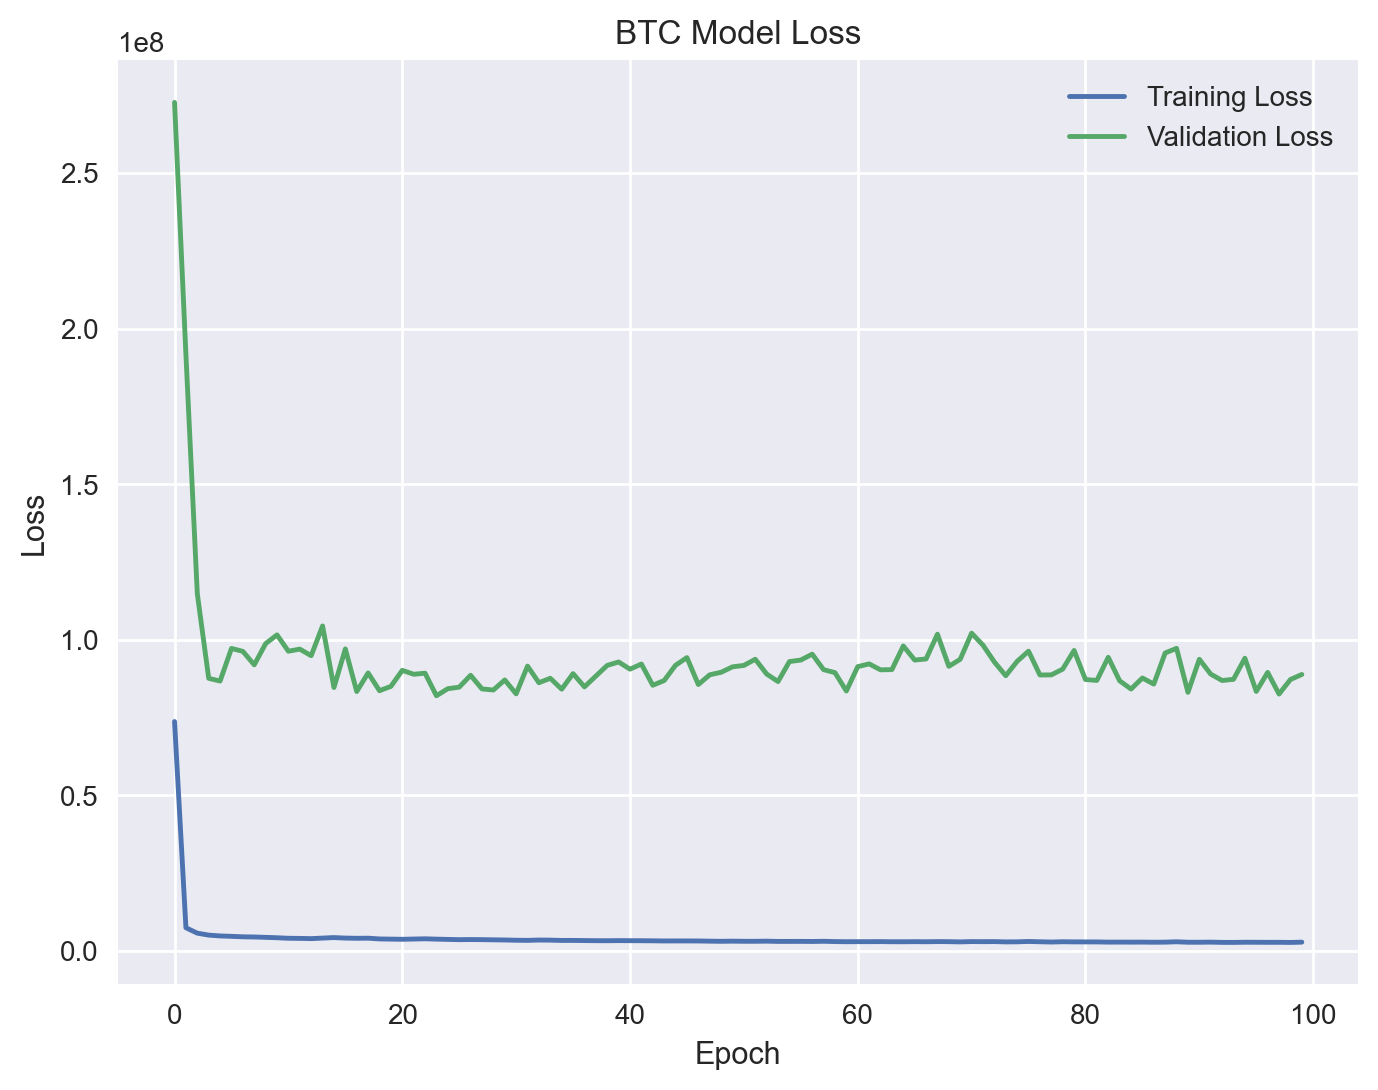

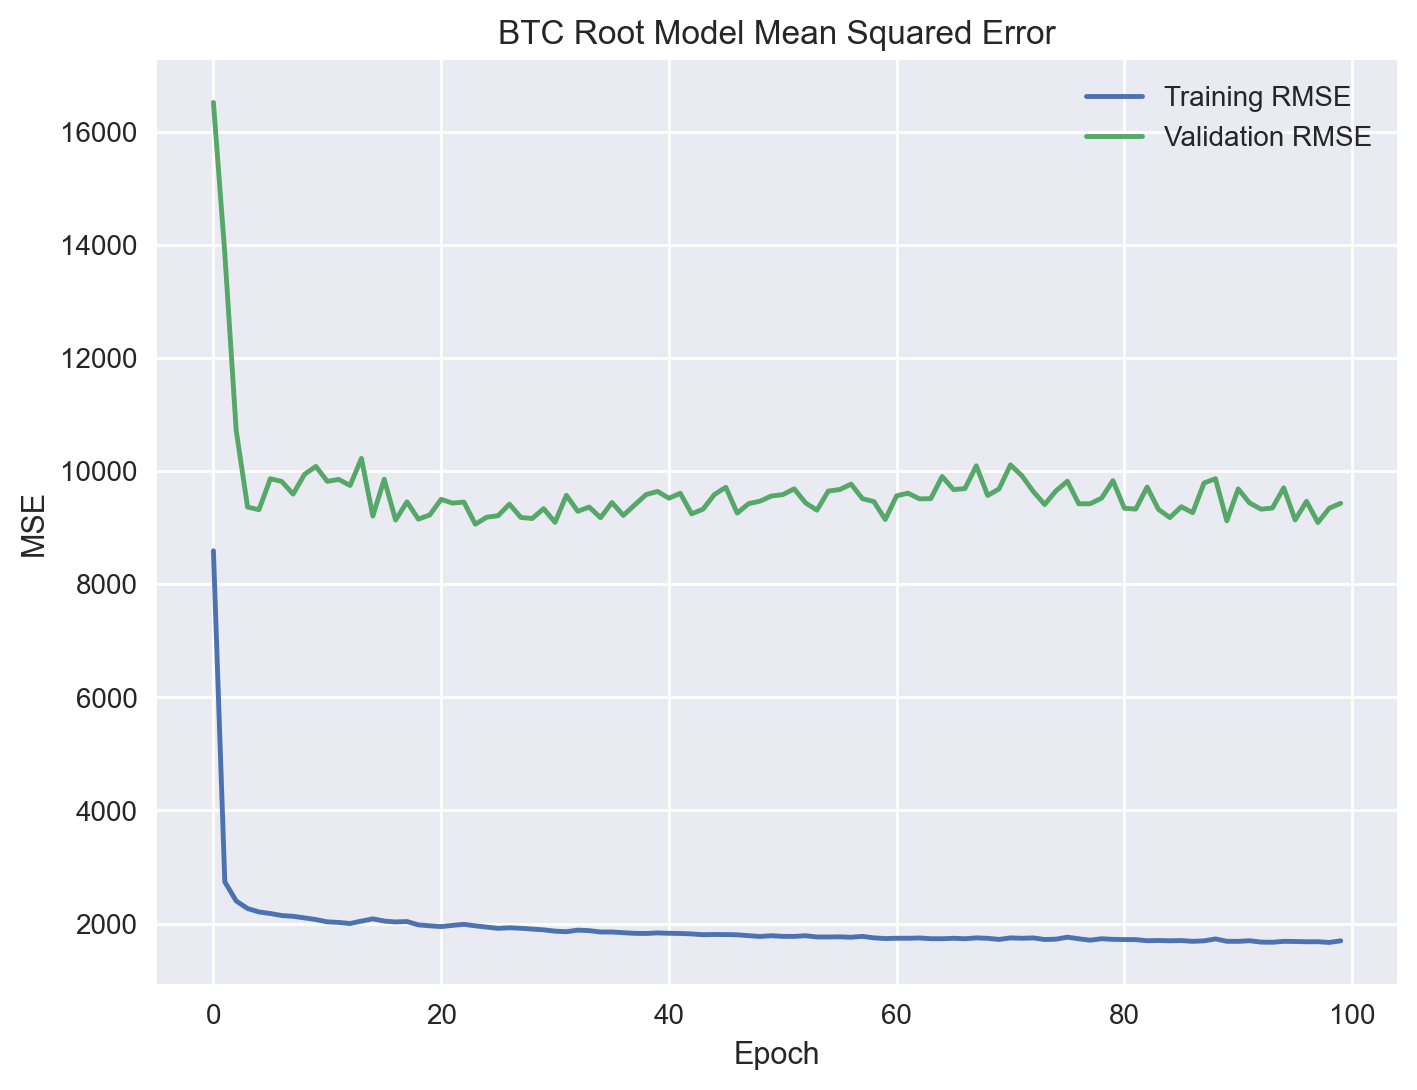

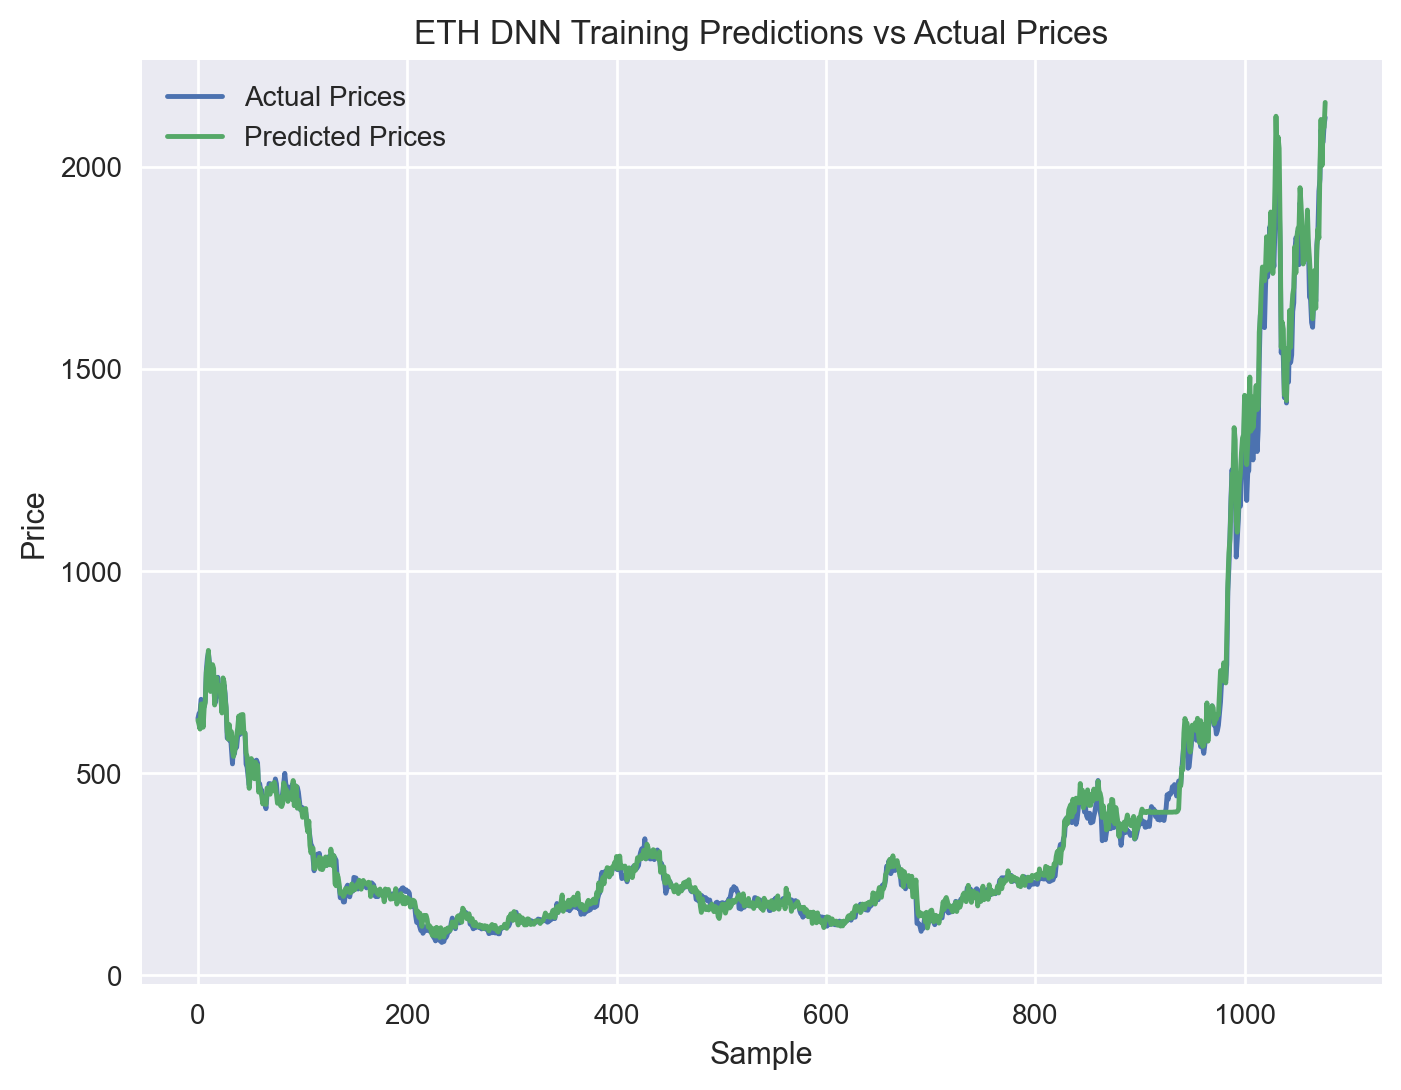

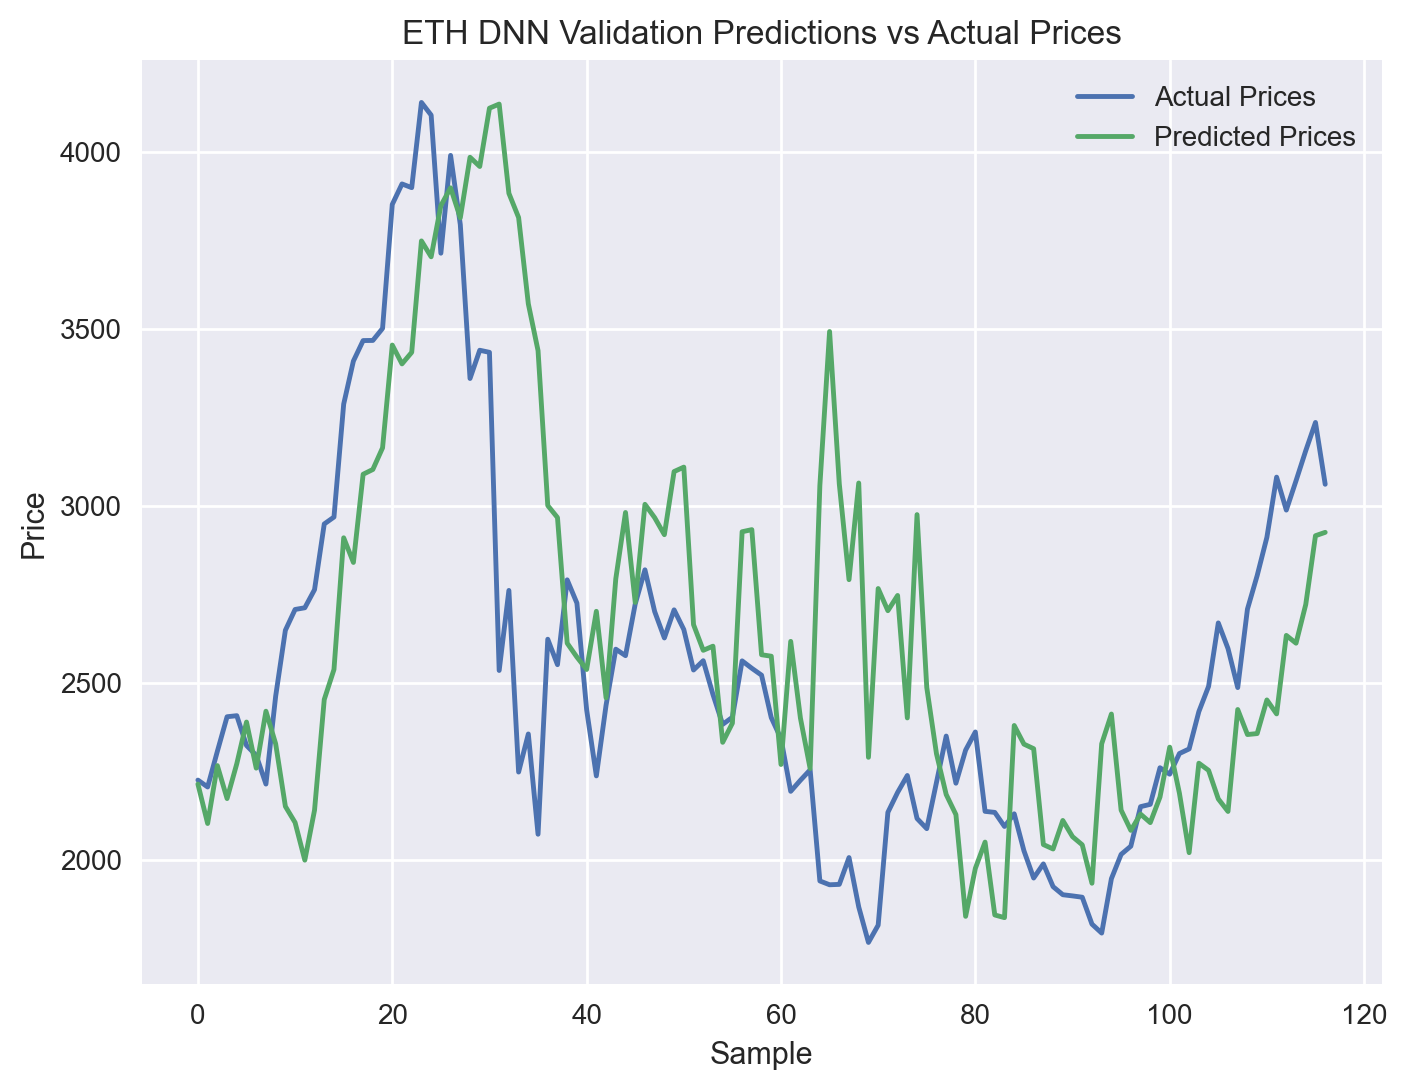

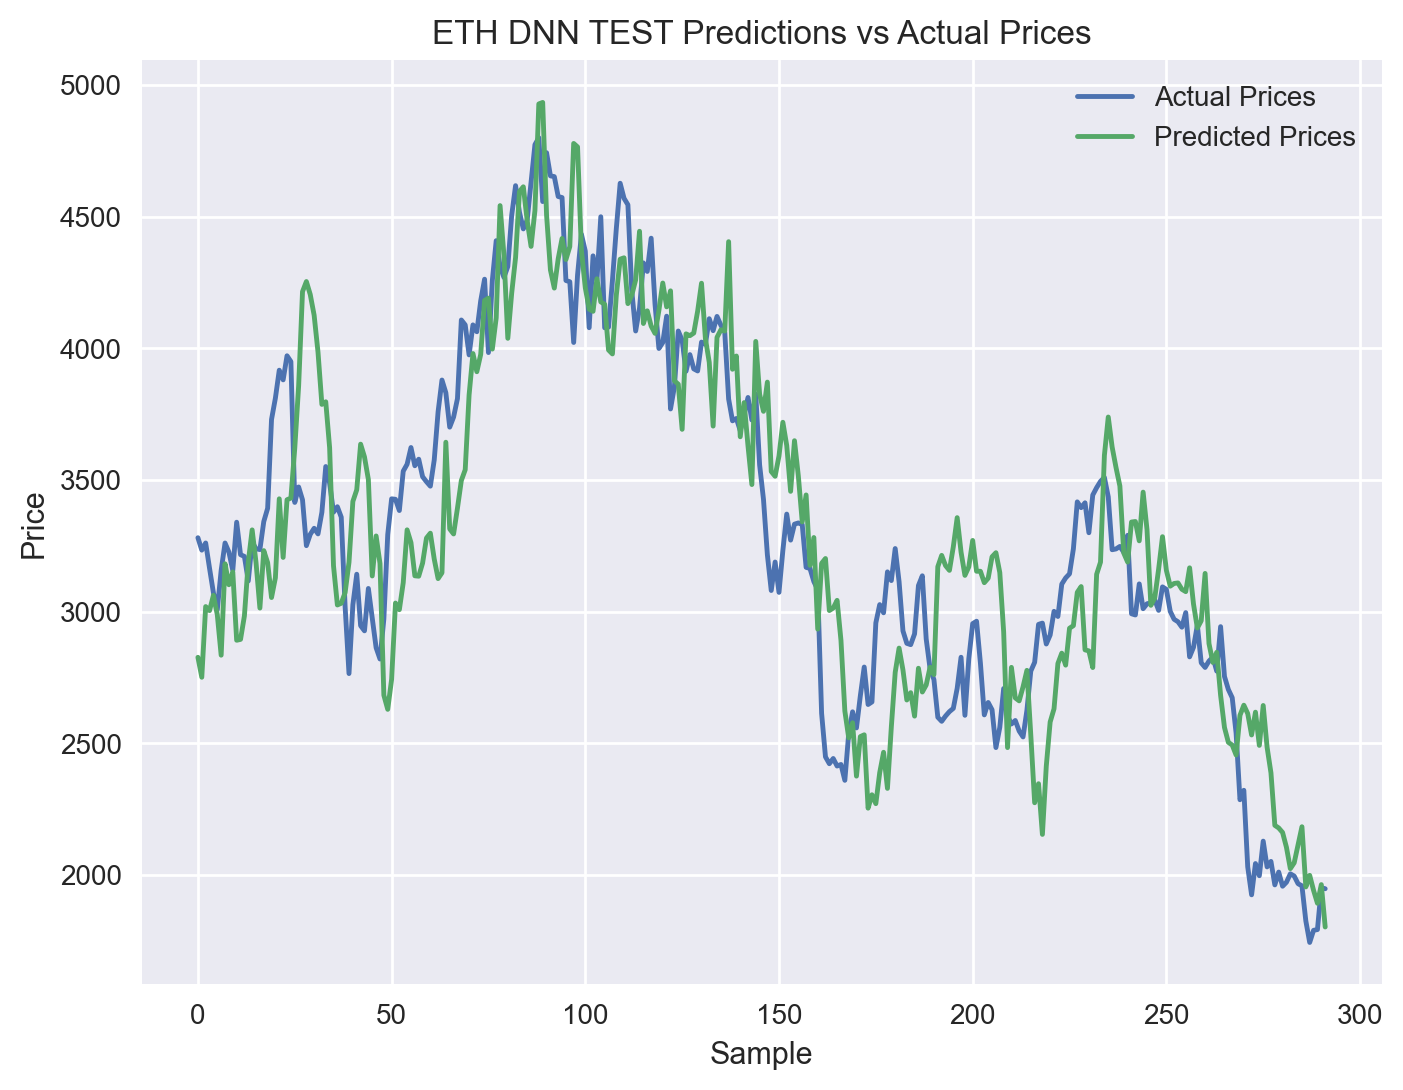

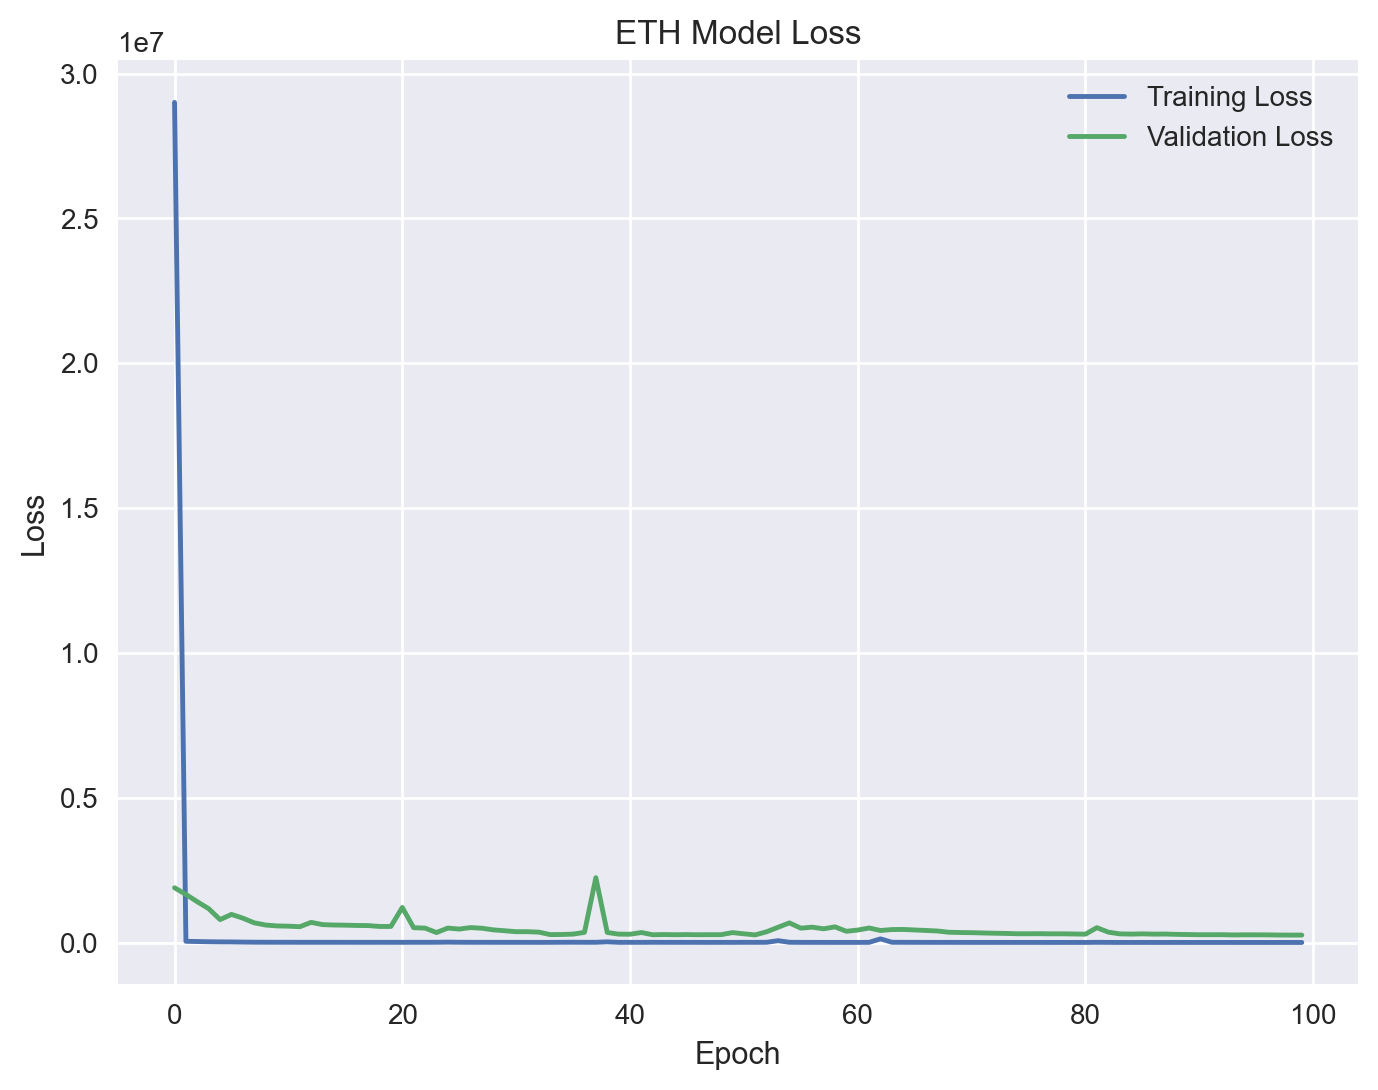

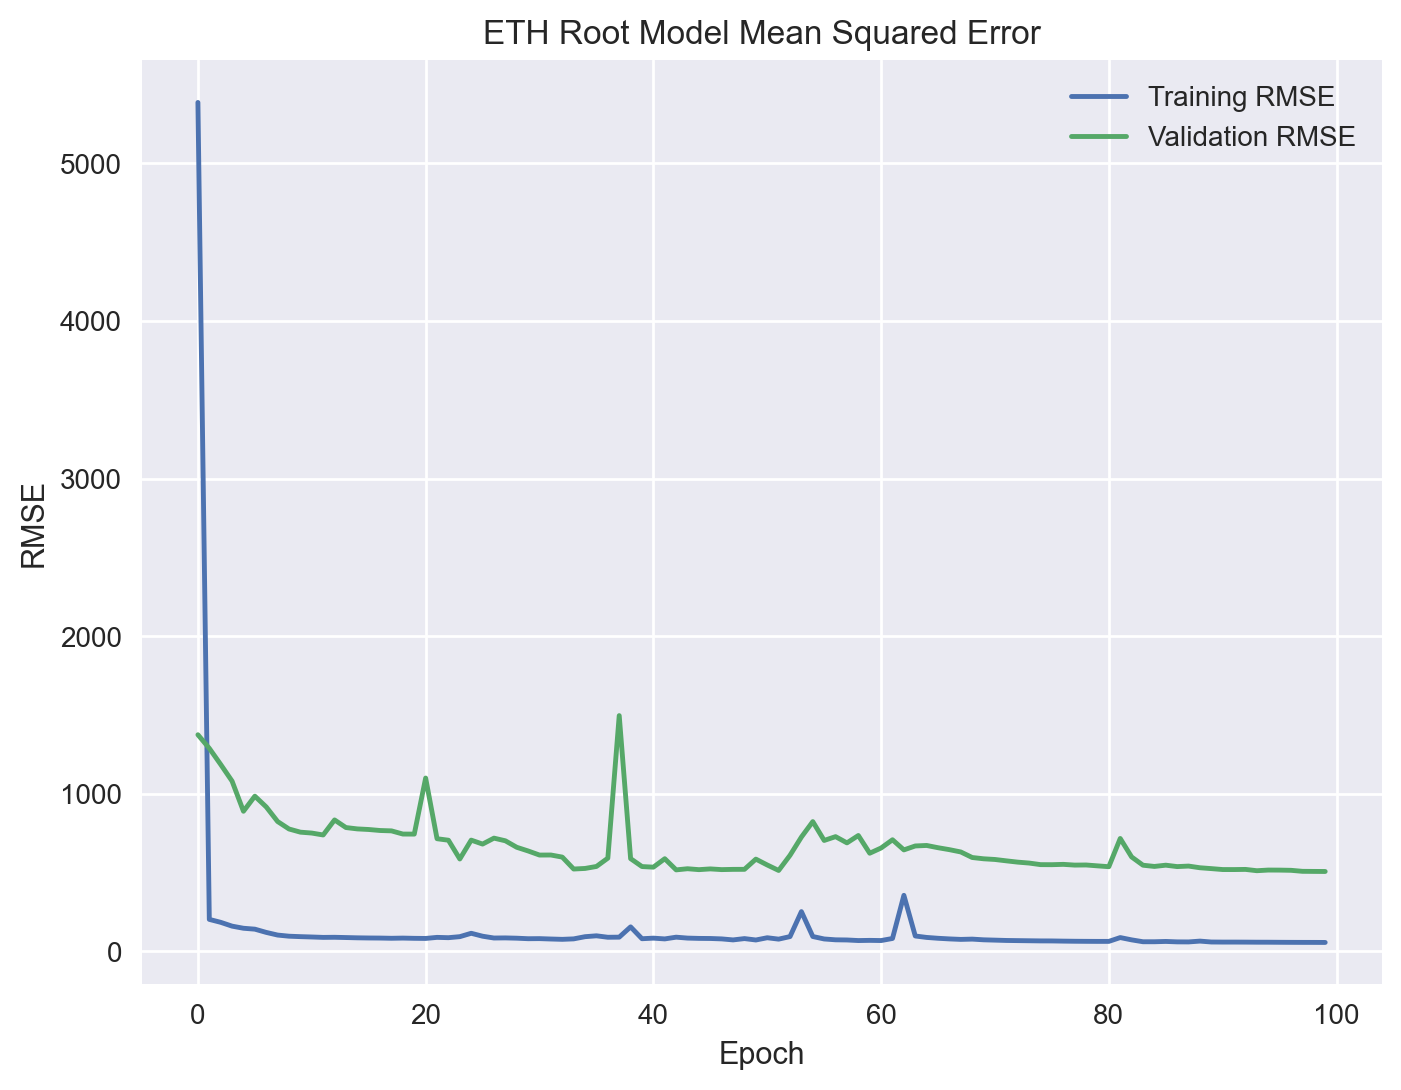

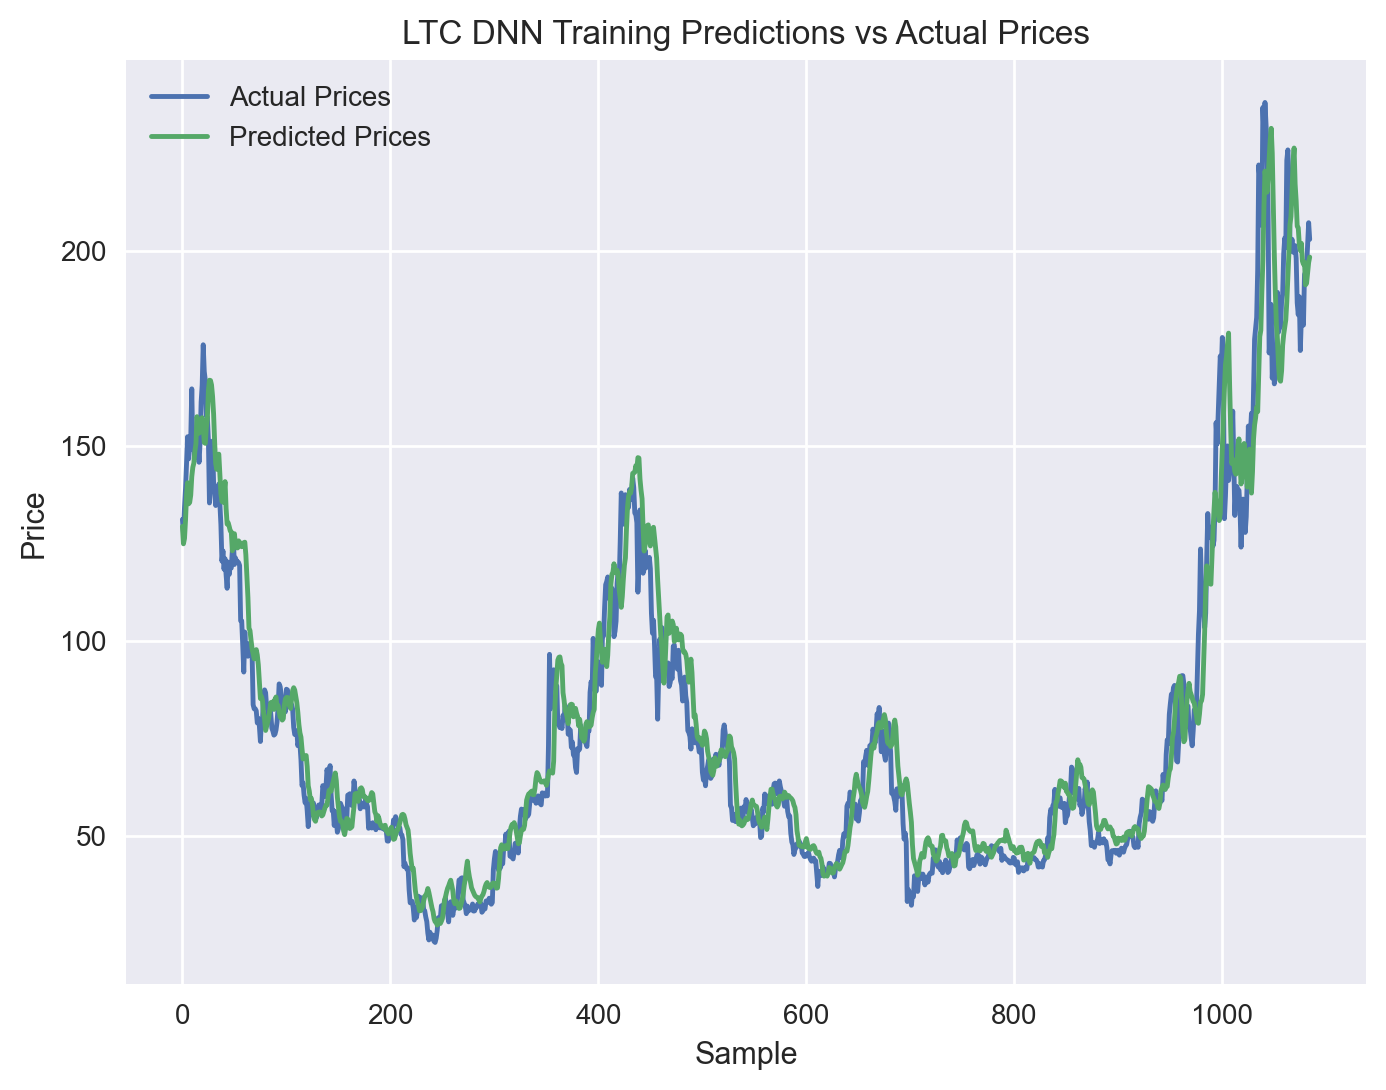

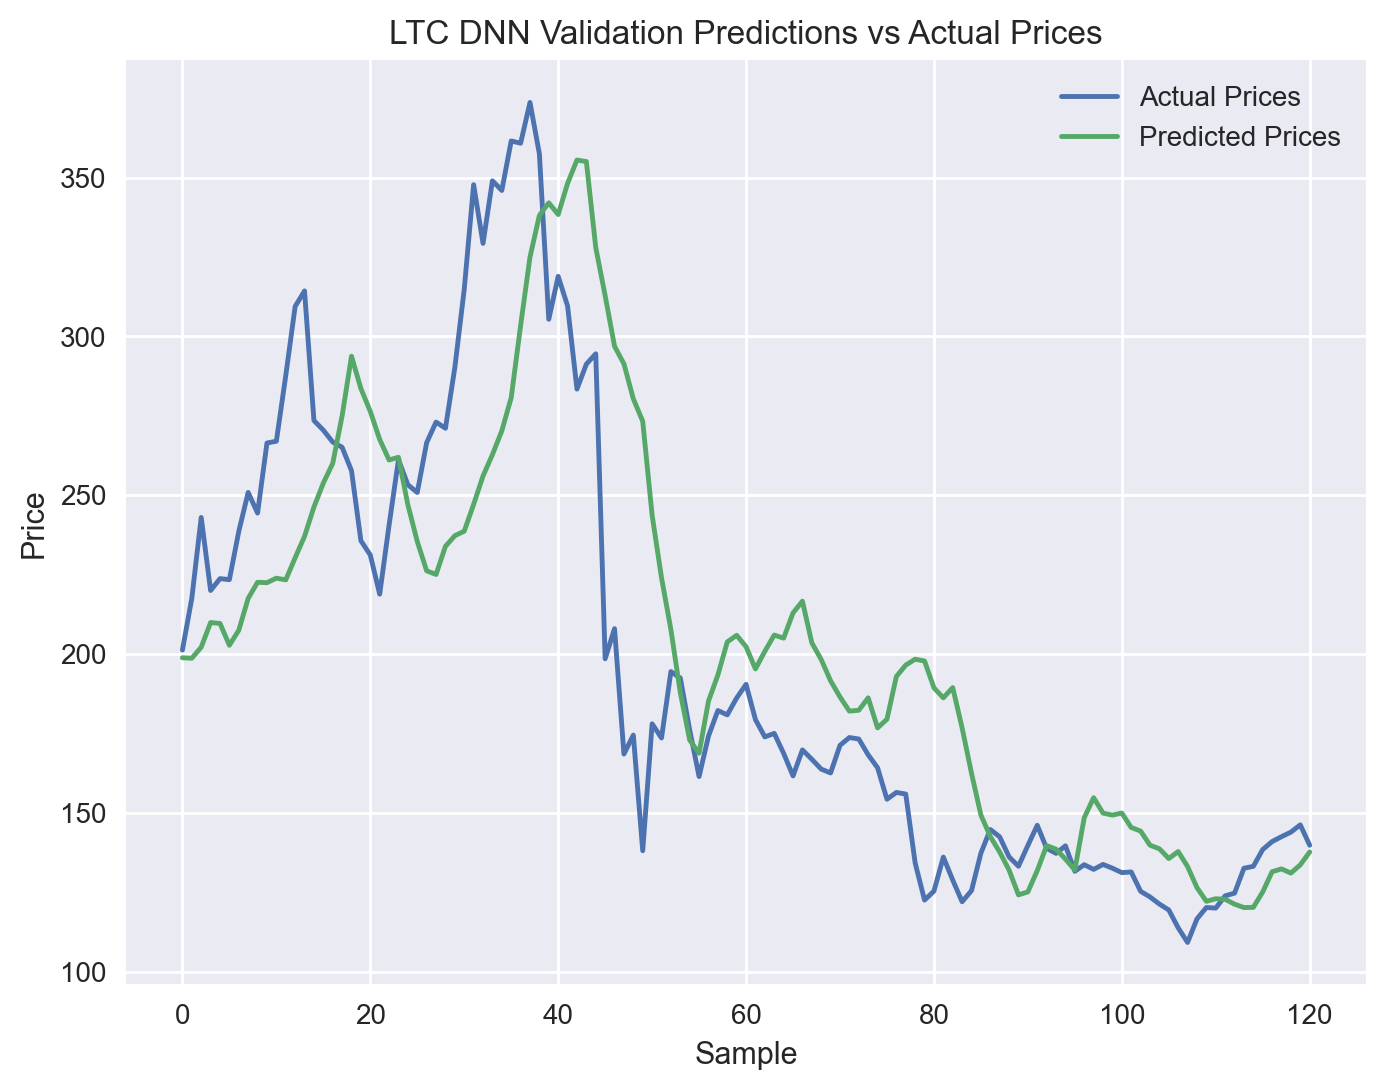

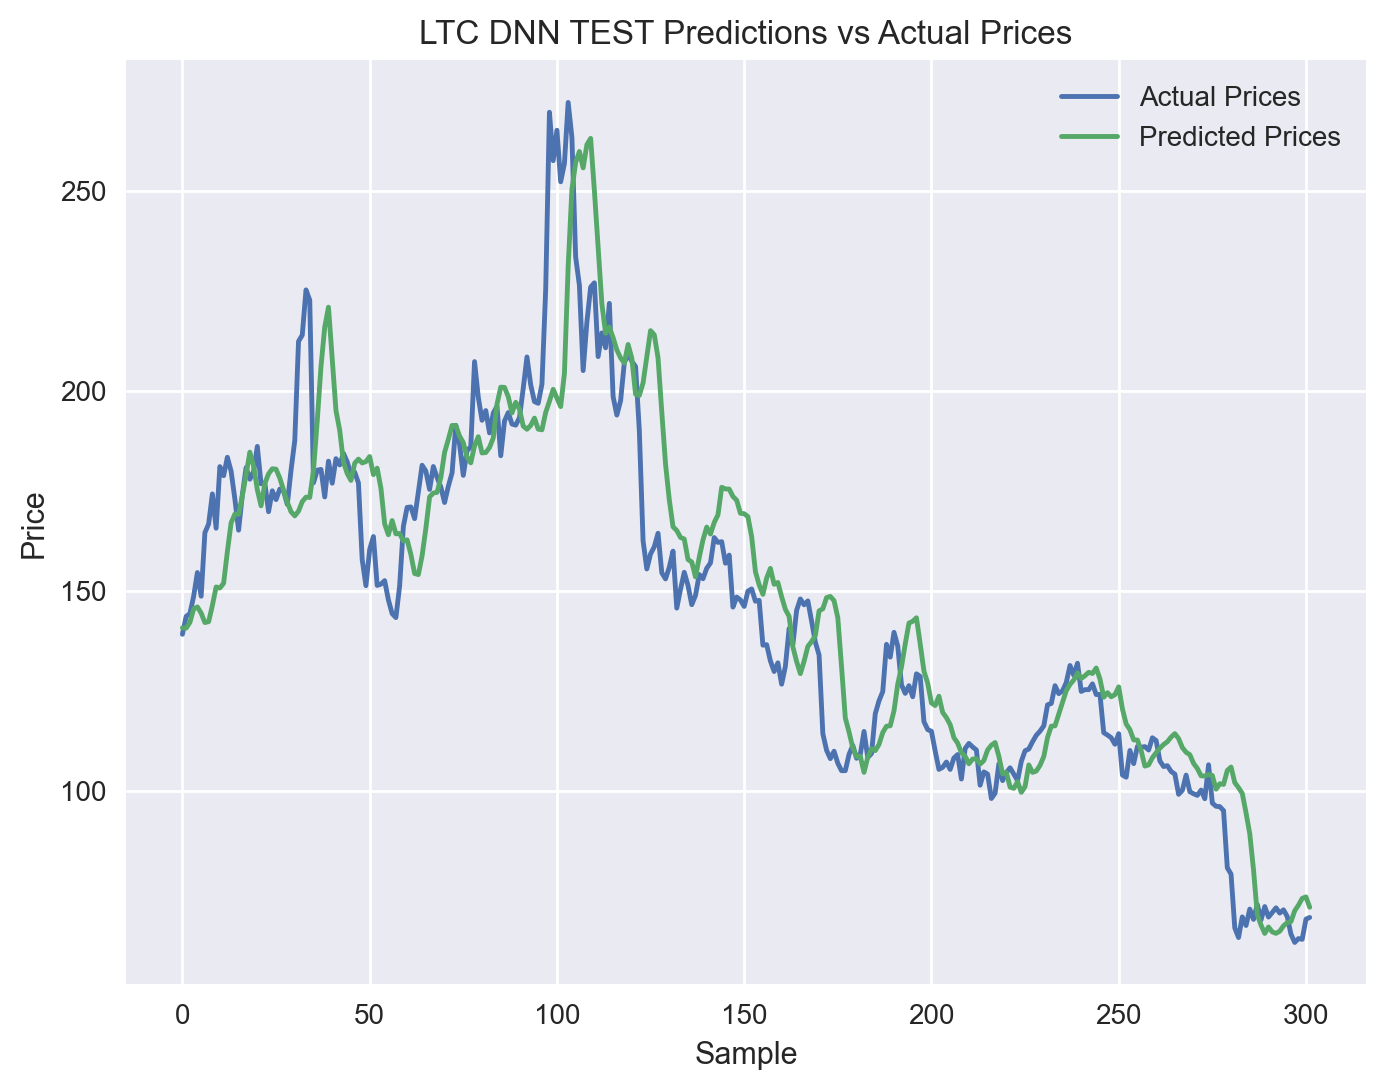

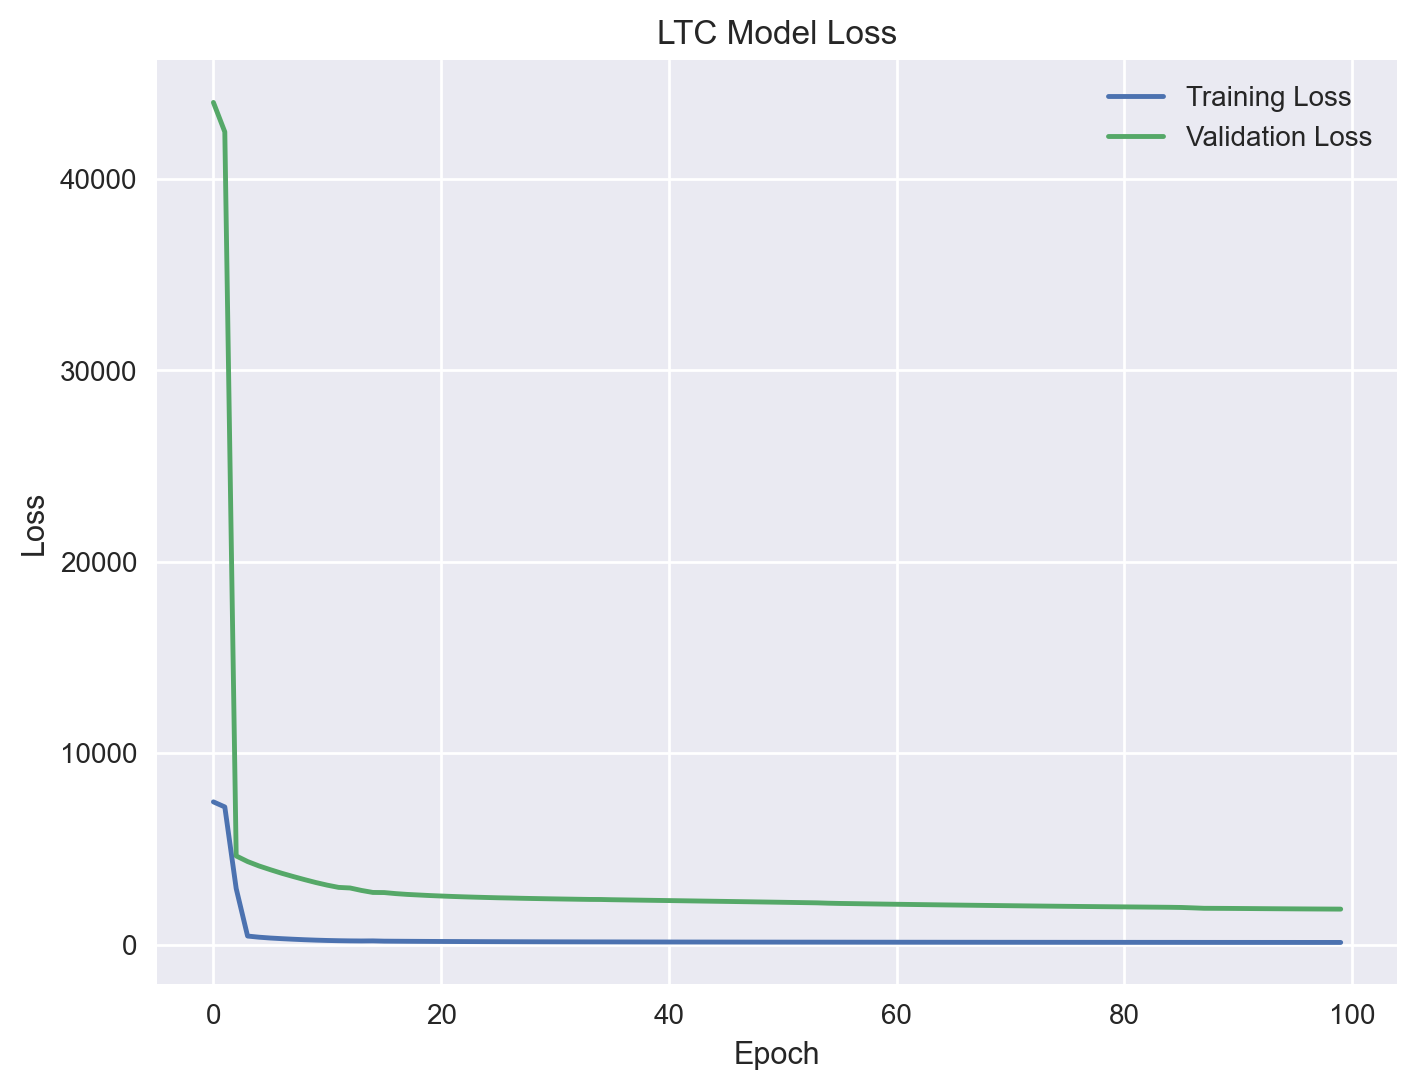

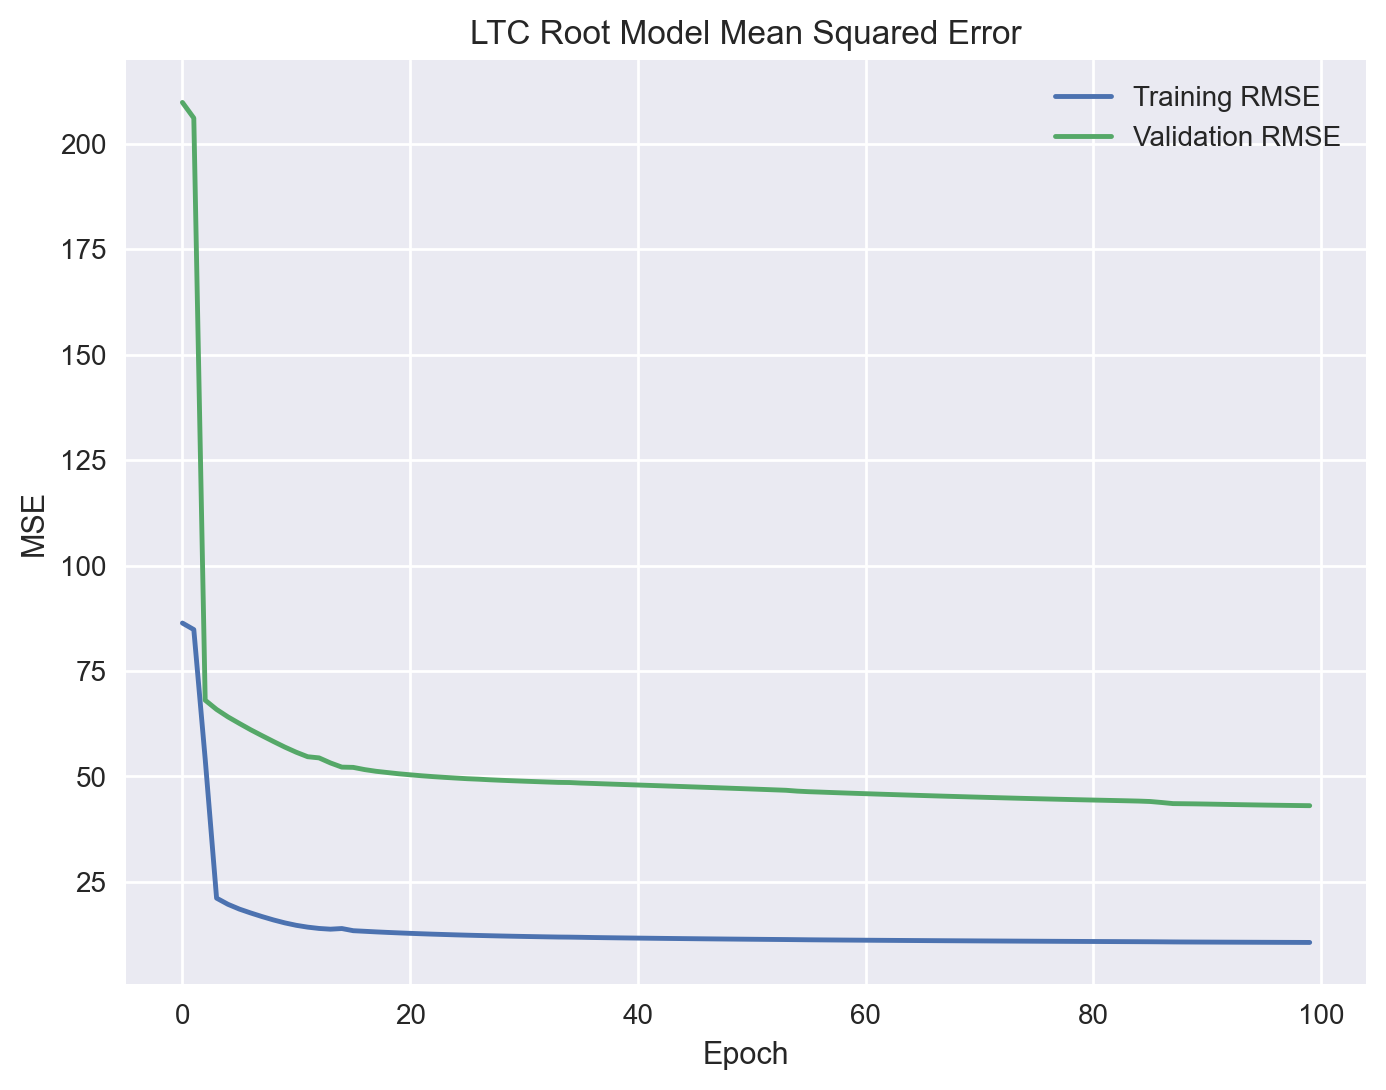

In [47]:
from IPython.display import Image, display

# Display the image
display(Image(filename='Images/btc_train.png'))
display(Image(filename='Images/btc_validation.png'))
display(Image(filename='Images/btc_test.png'))
display(Image(filename='Images/btc_model_loss.png'))
display(Image(filename='Images/btc_rmse.png'))
display(Image(filename='Images/eth_train.png'))
display(Image(filename='Images/eth_validation.png'))
display(Image(filename='Images/eth_test.png'))
display(Image(filename='Images/eth_model_loss.png'))
display(Image(filename='Images/eth_rmse.png'))
display(Image(filename='Images/ltc_train.png'))
display(Image(filename='Images/ltc_validation.png'))
display(Image(filename='Images/ltc_test.png'))
display(Image(filename='Images/ltc_model_loss.png'))
display(Image(filename='Images/ltc_rmse.png'))

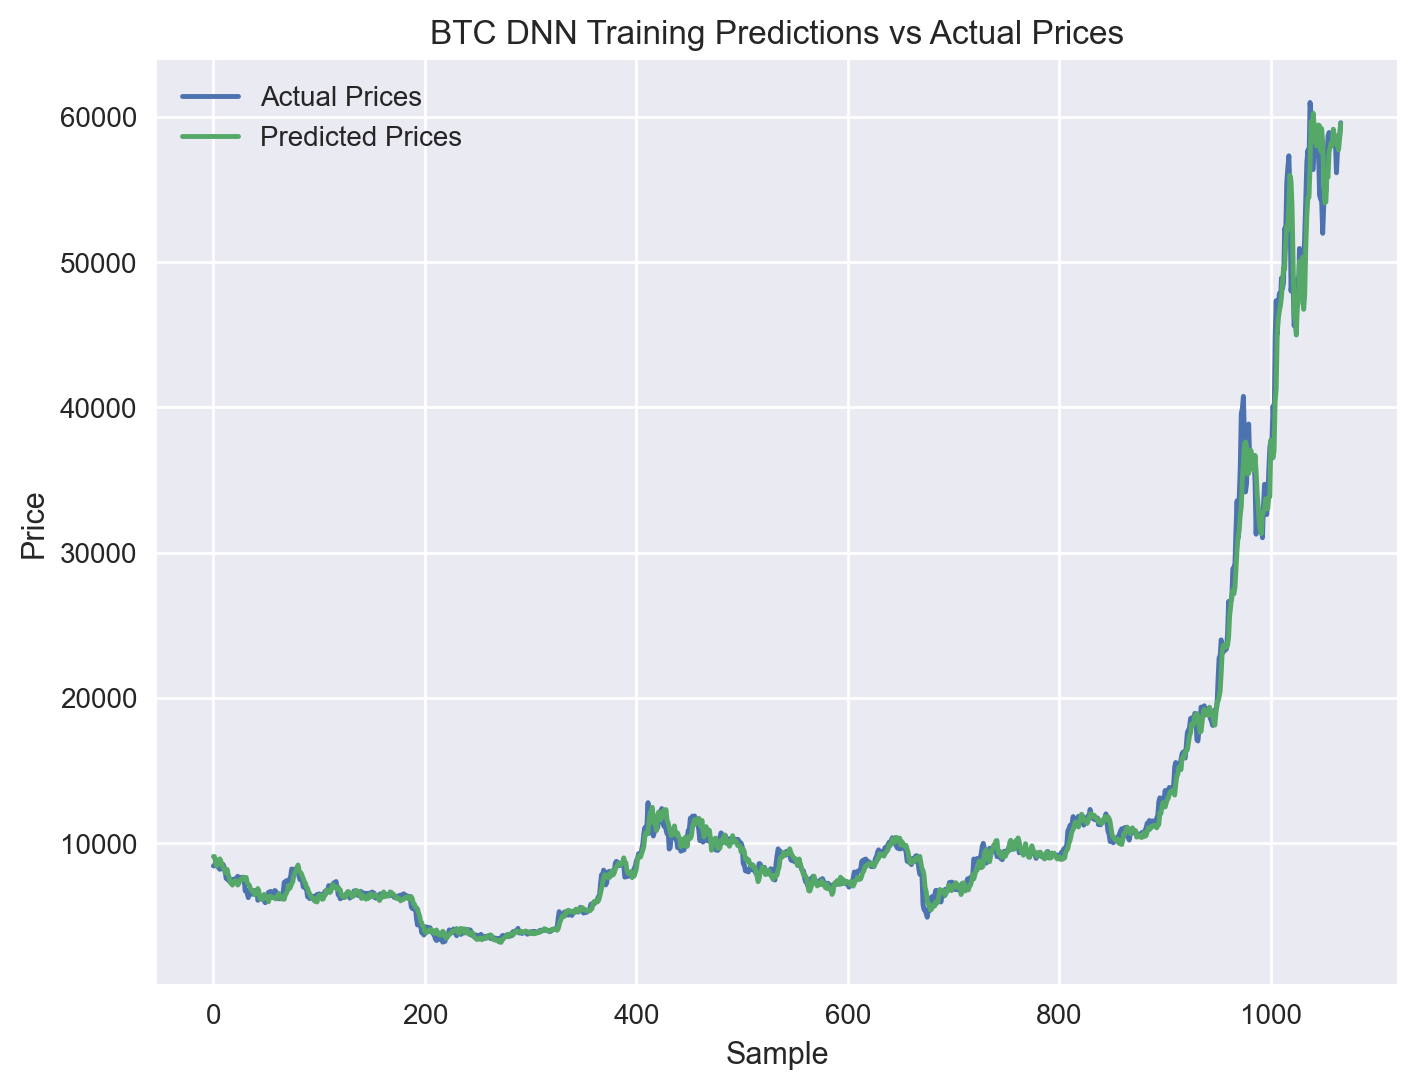

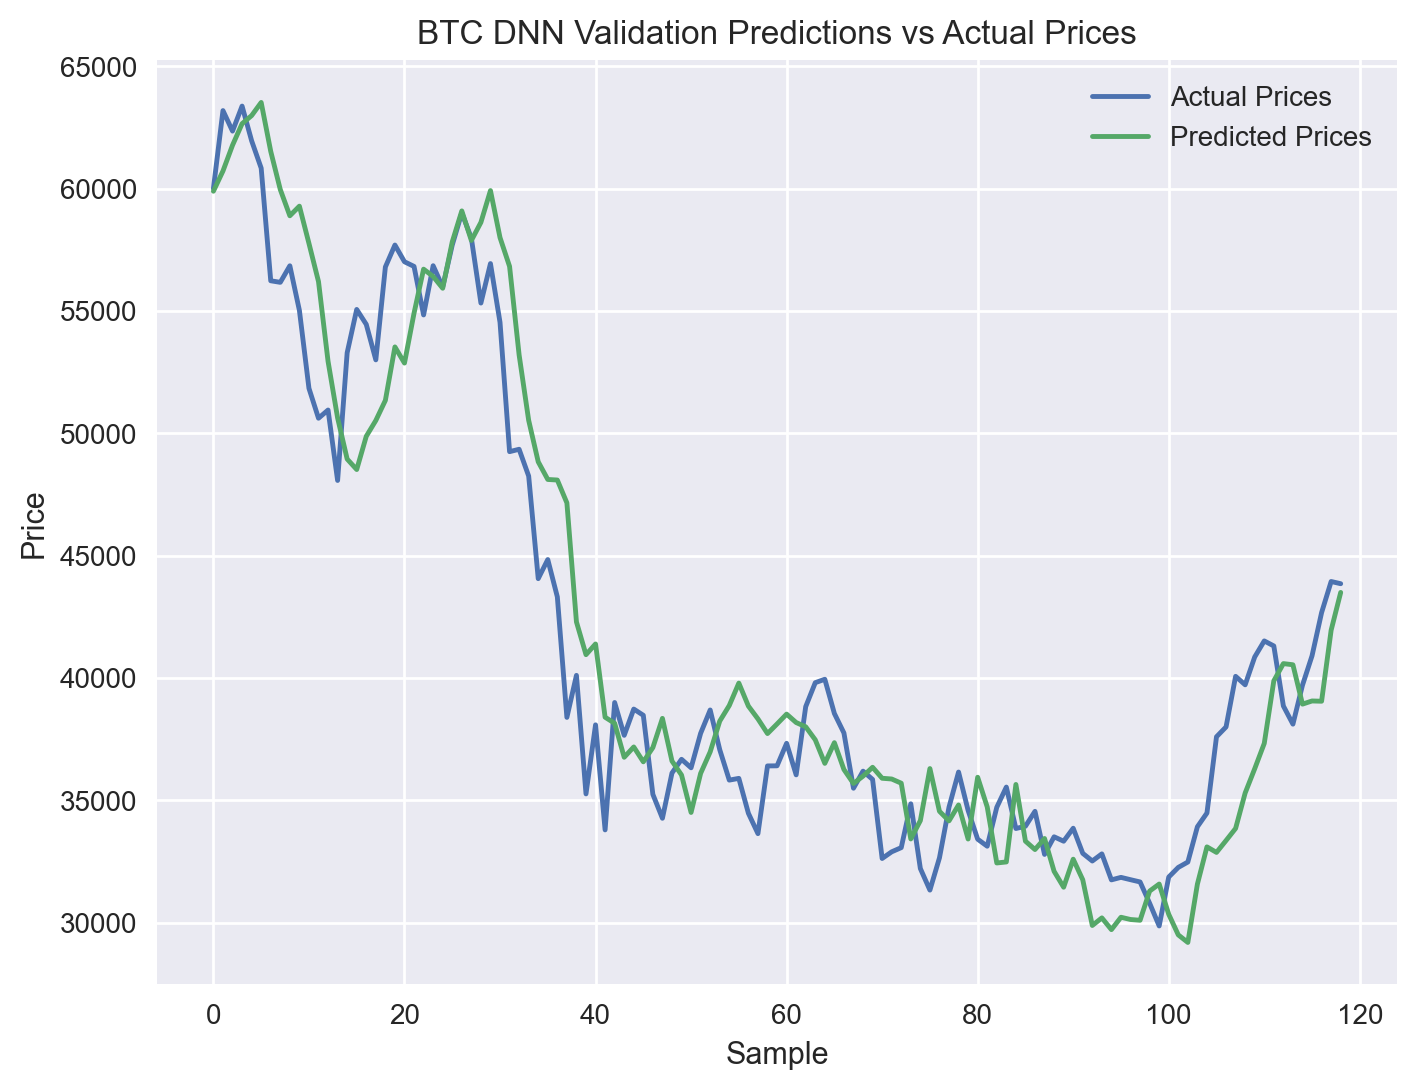

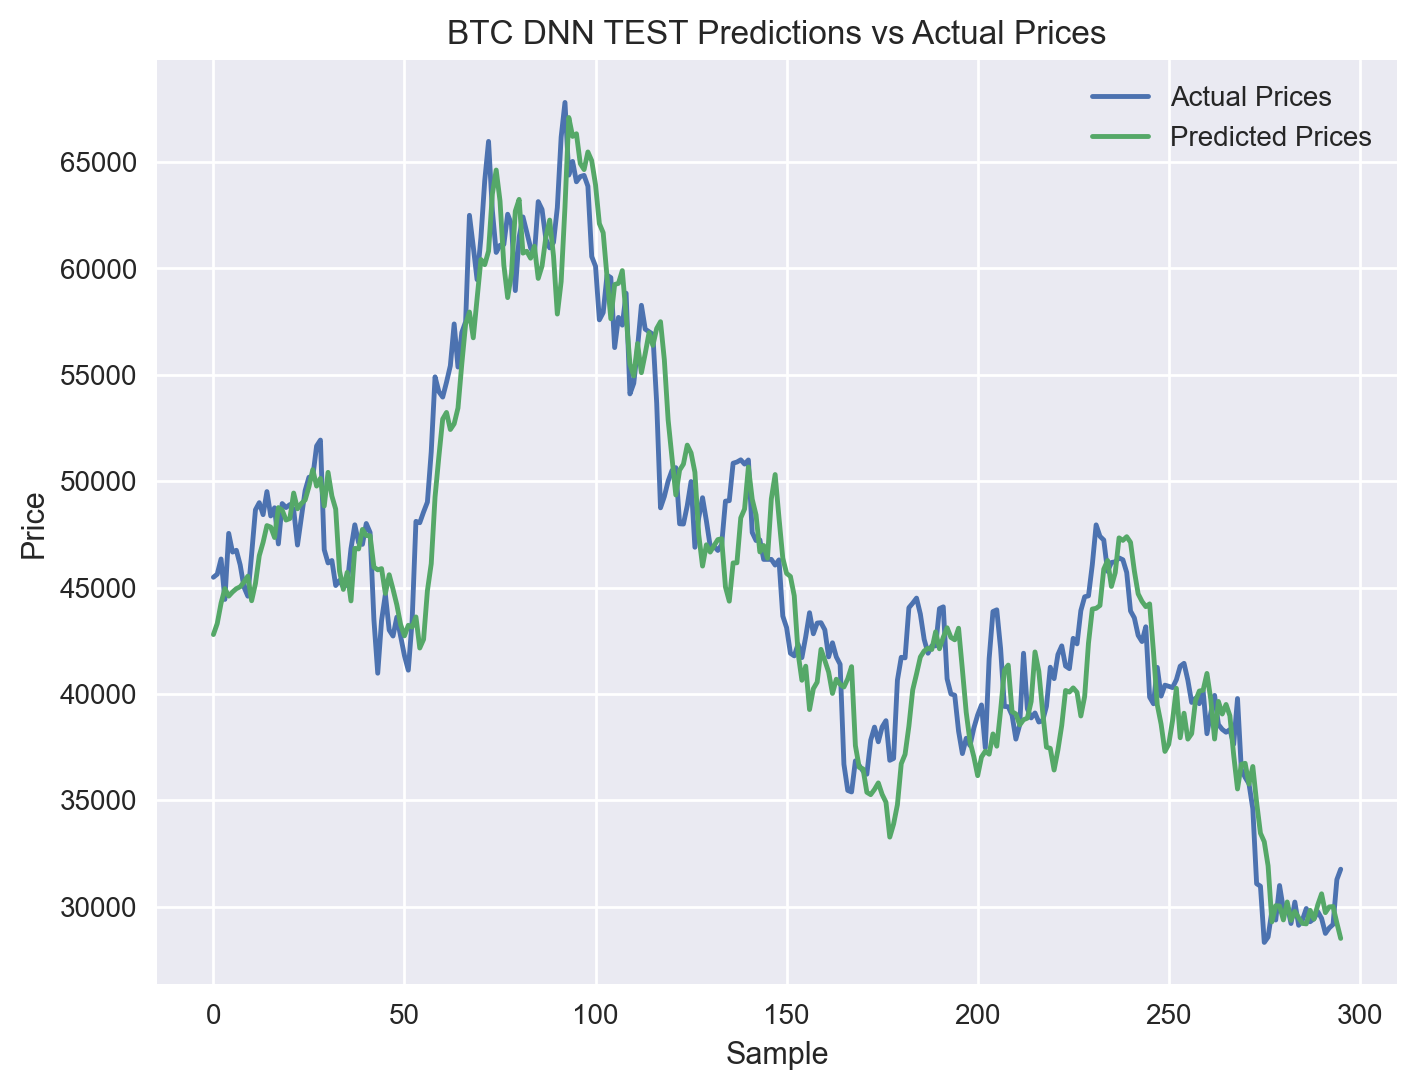

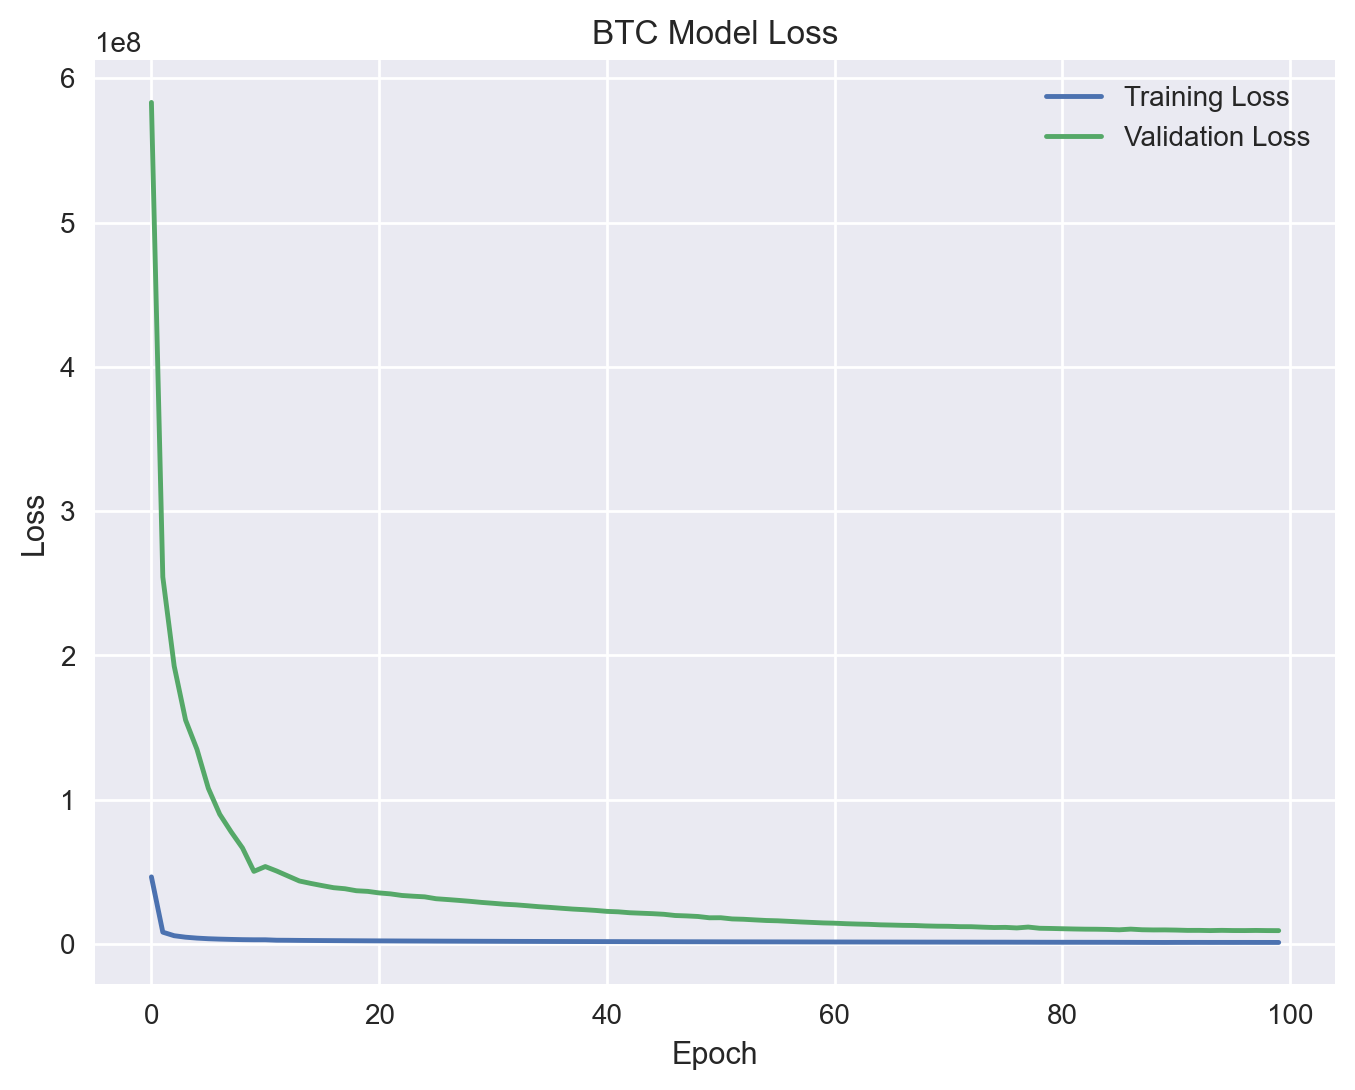

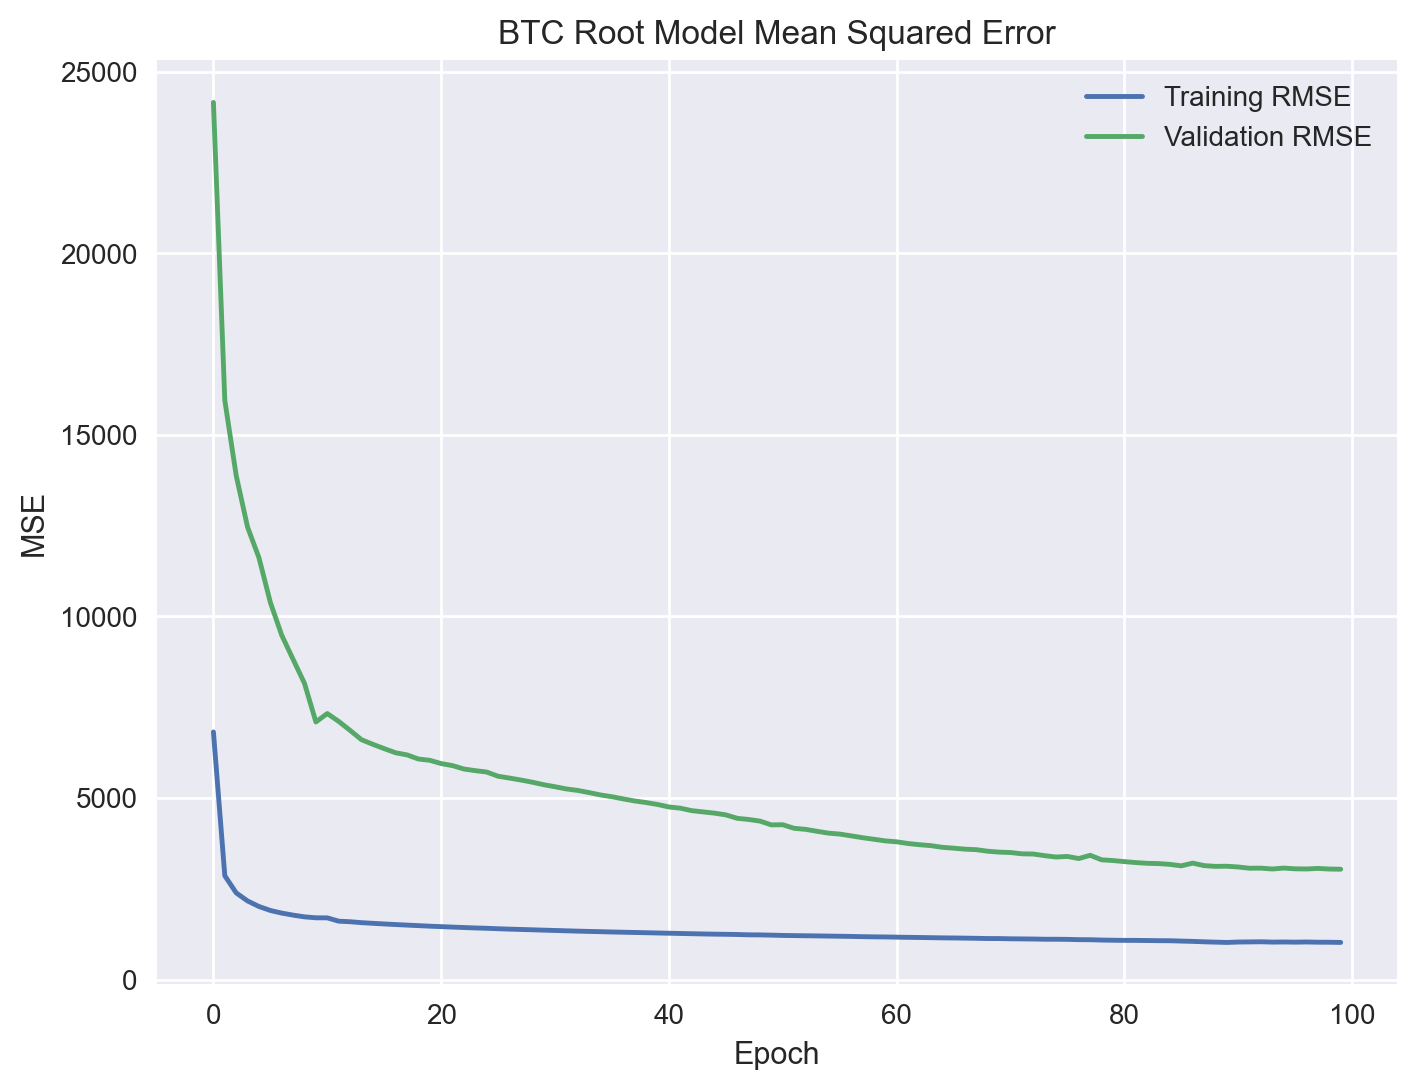

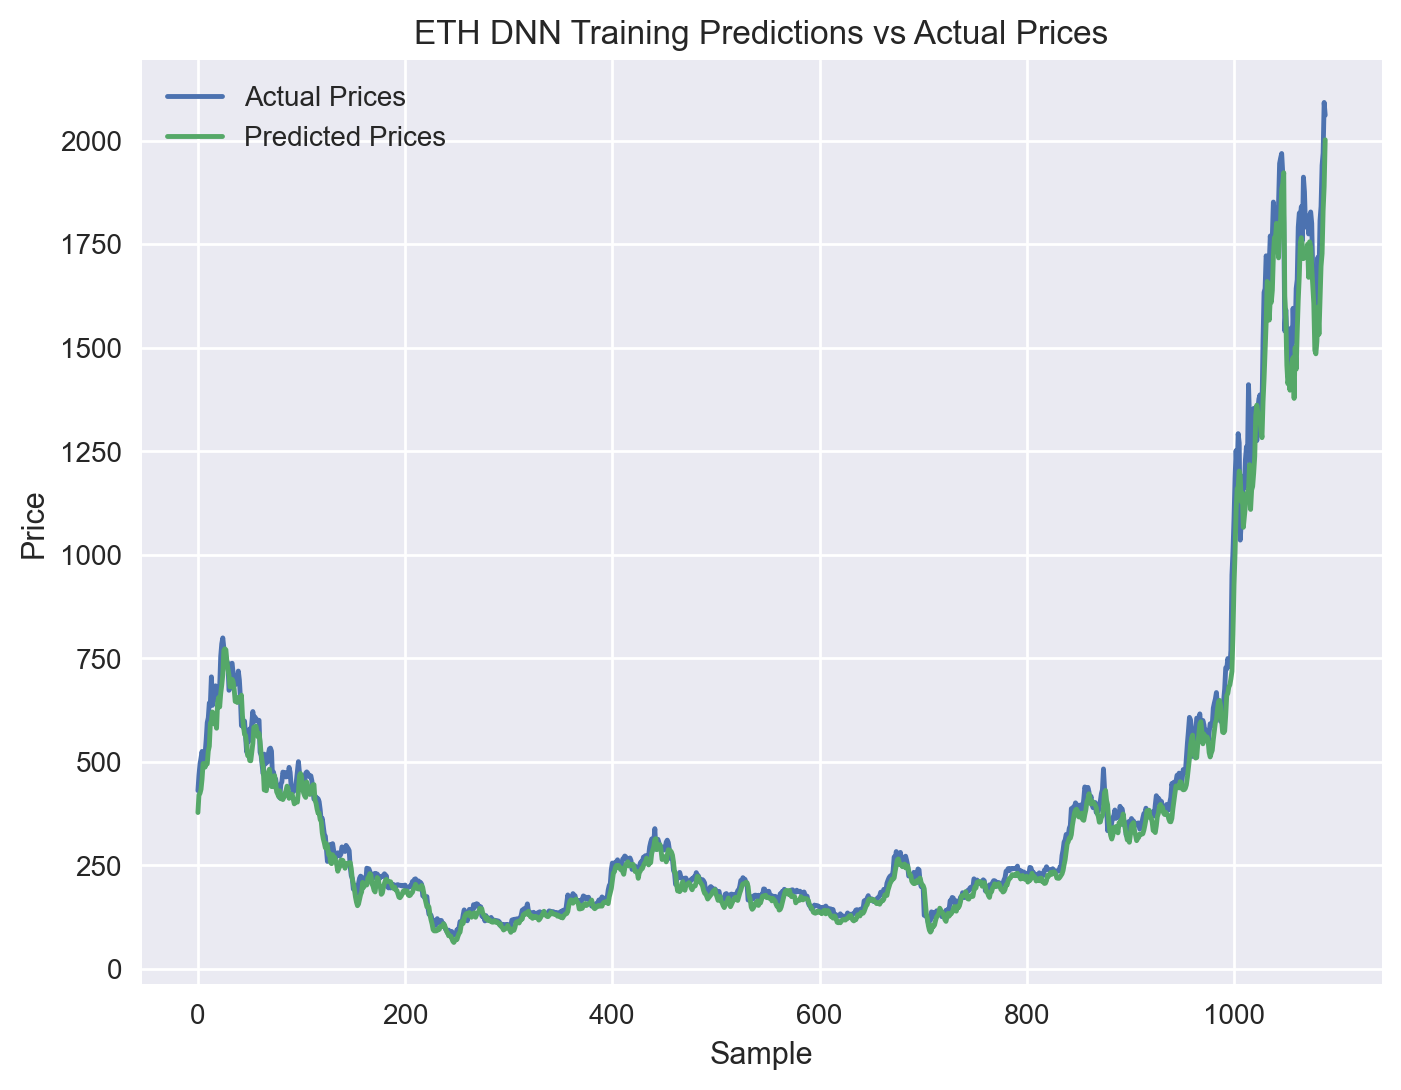

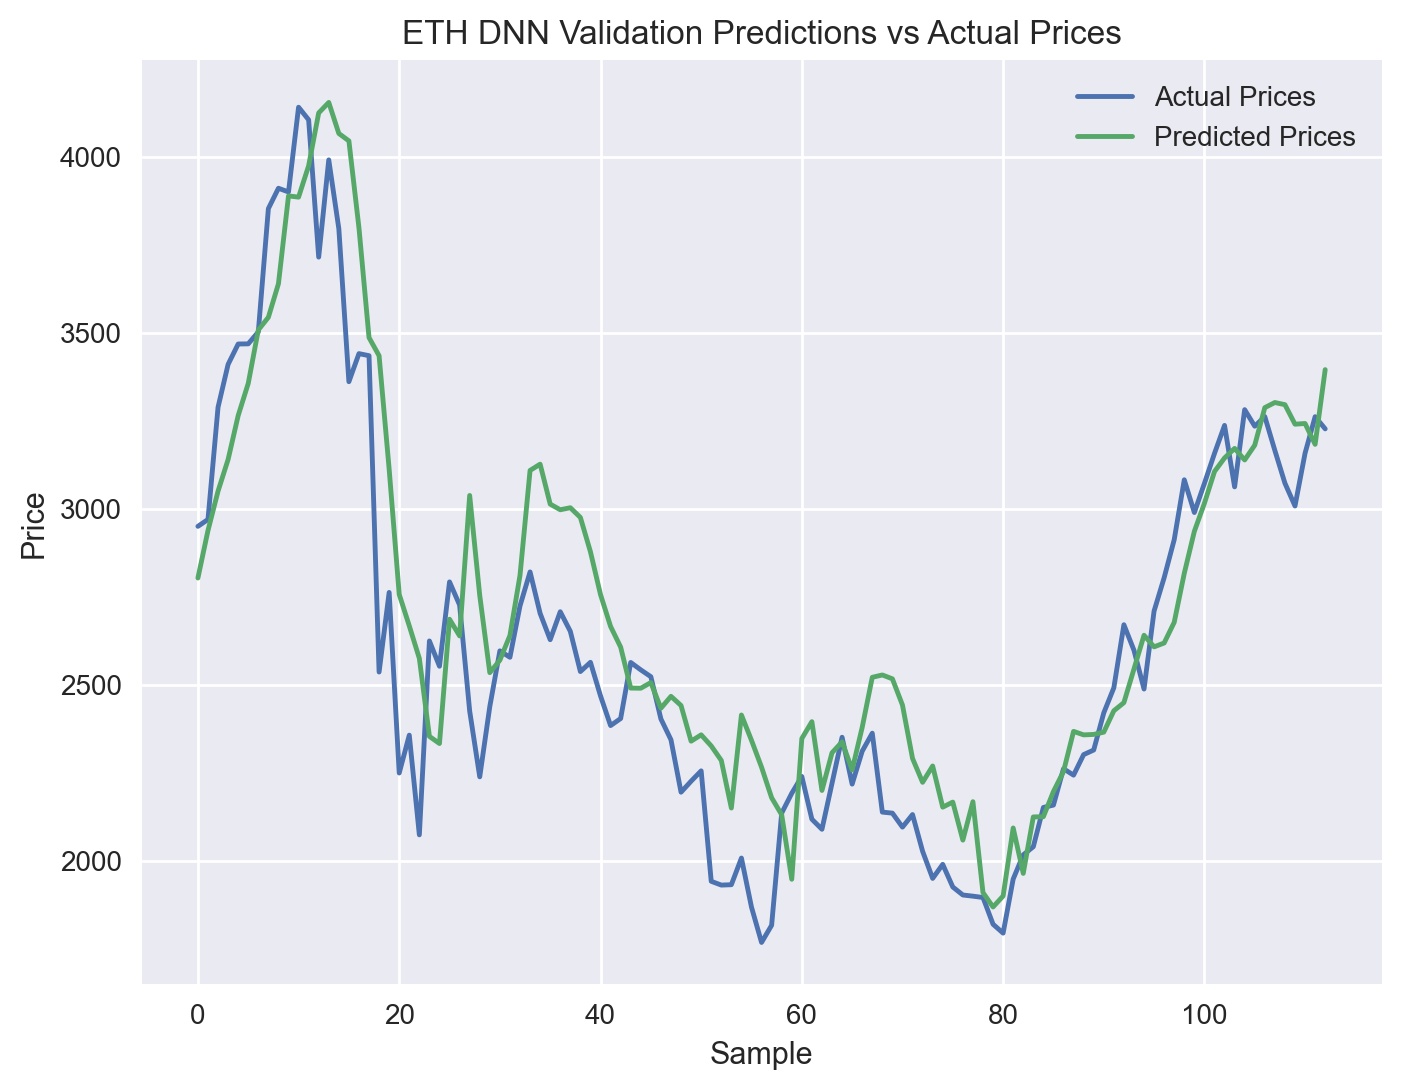

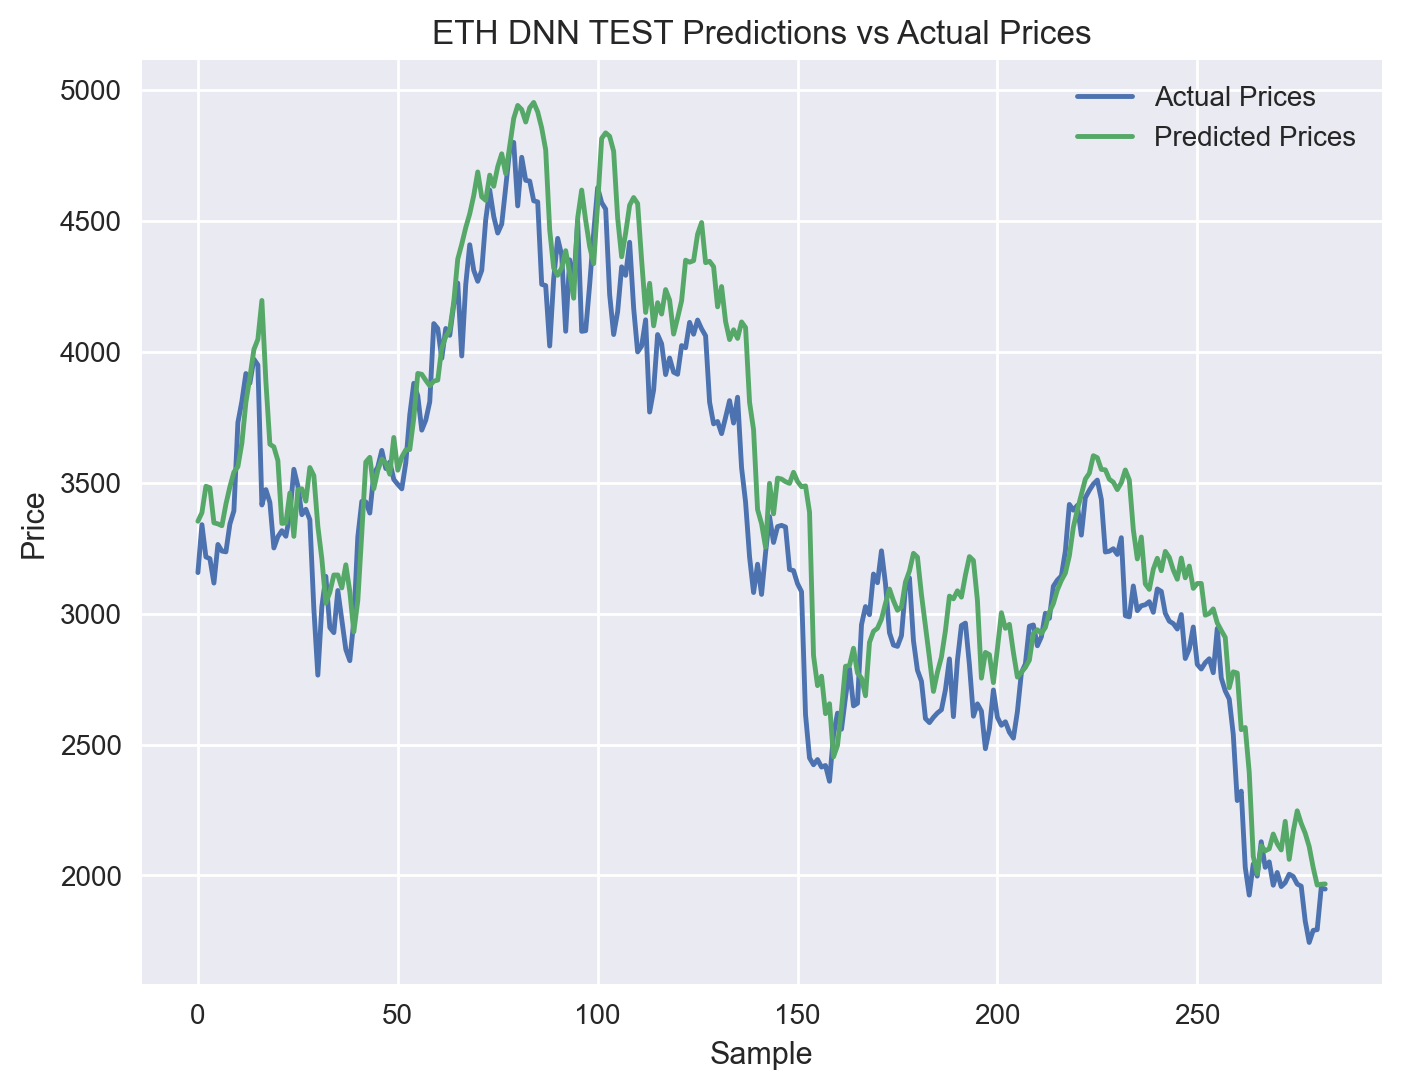

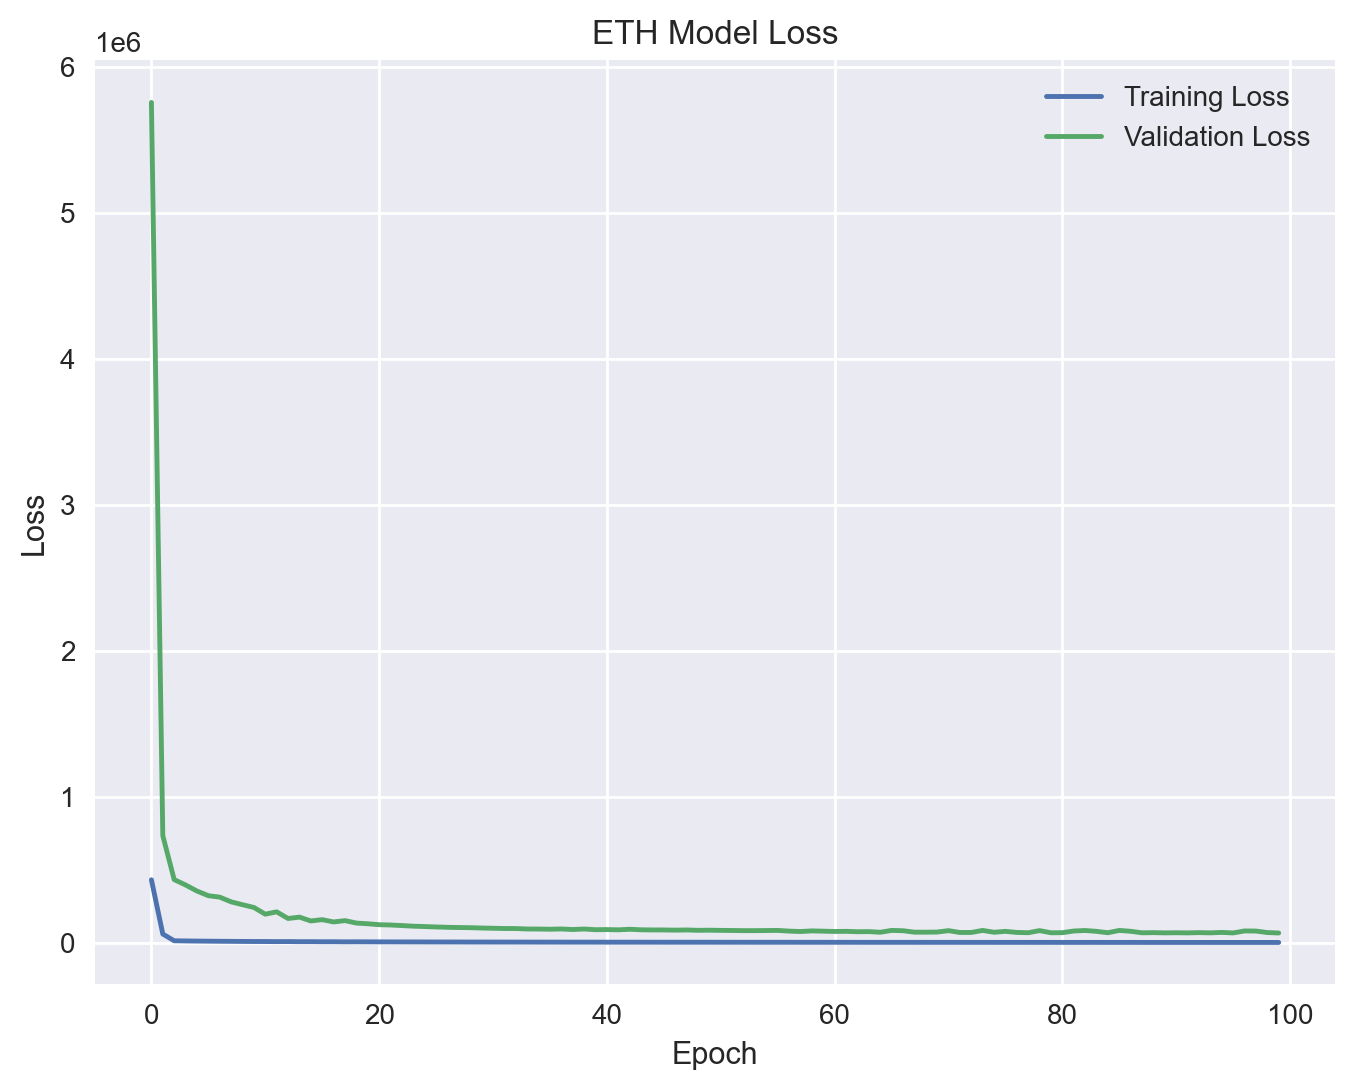

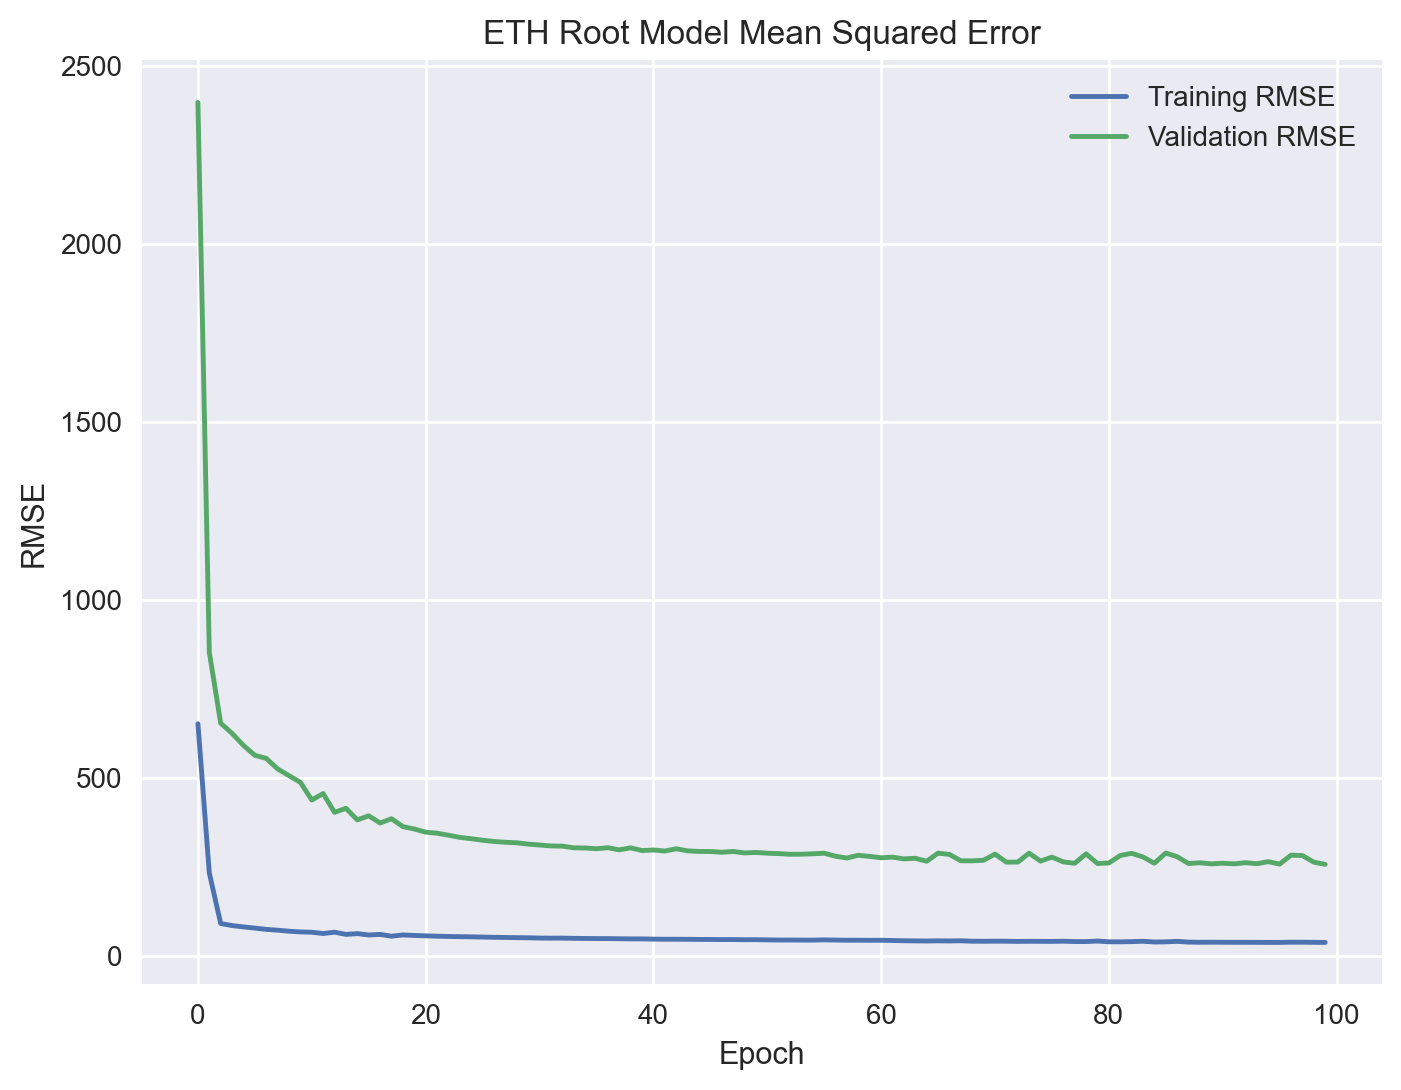

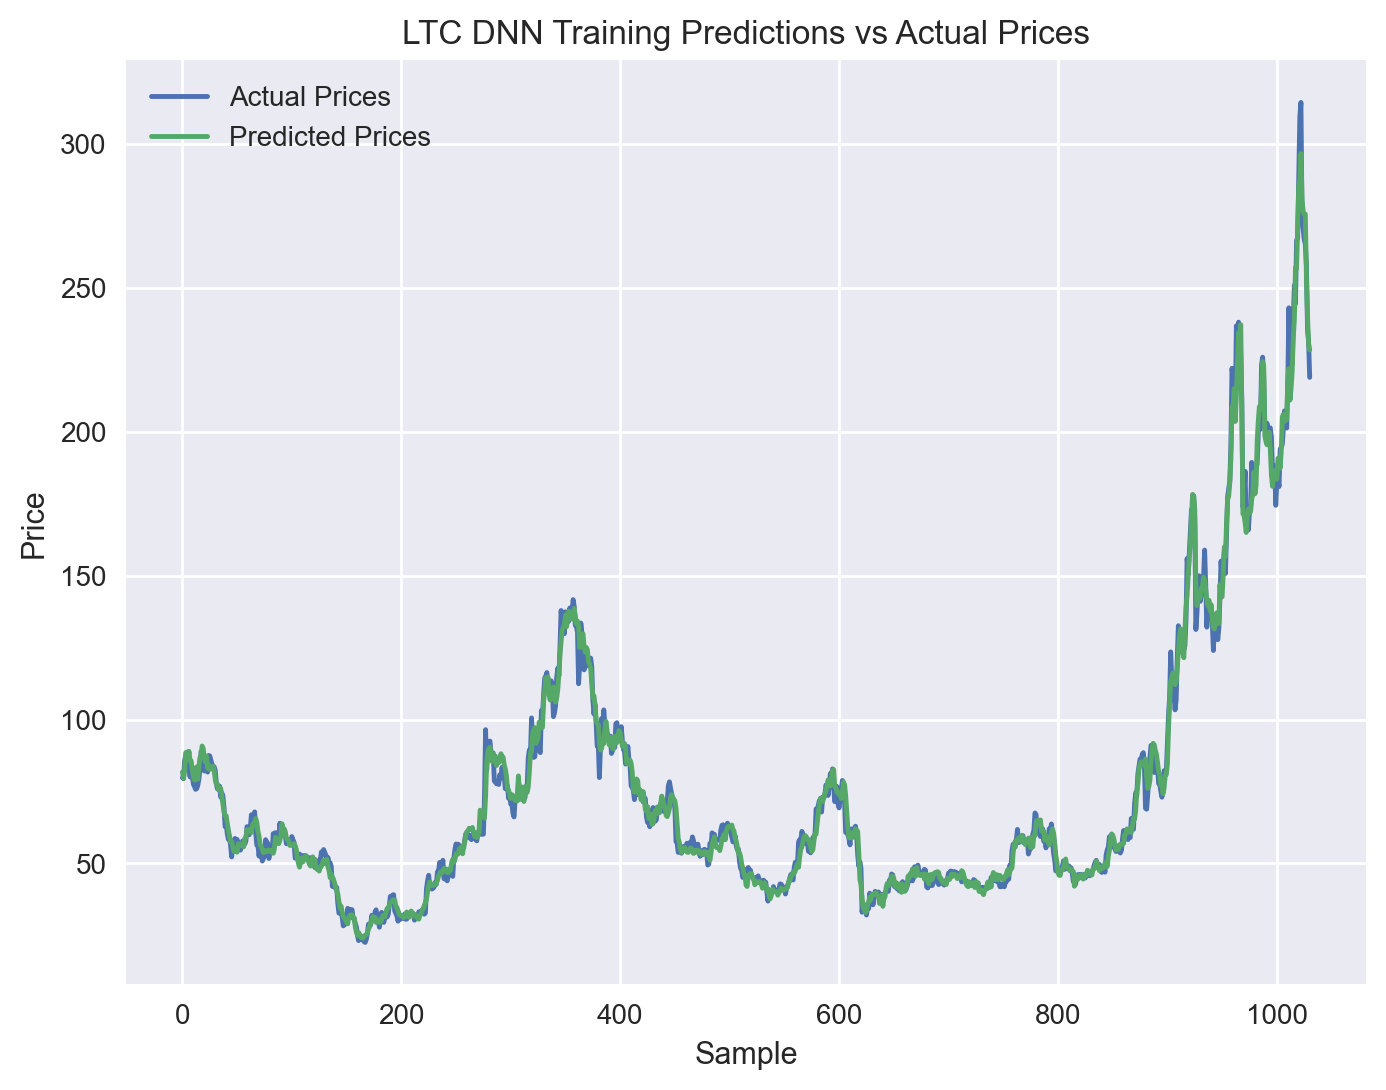

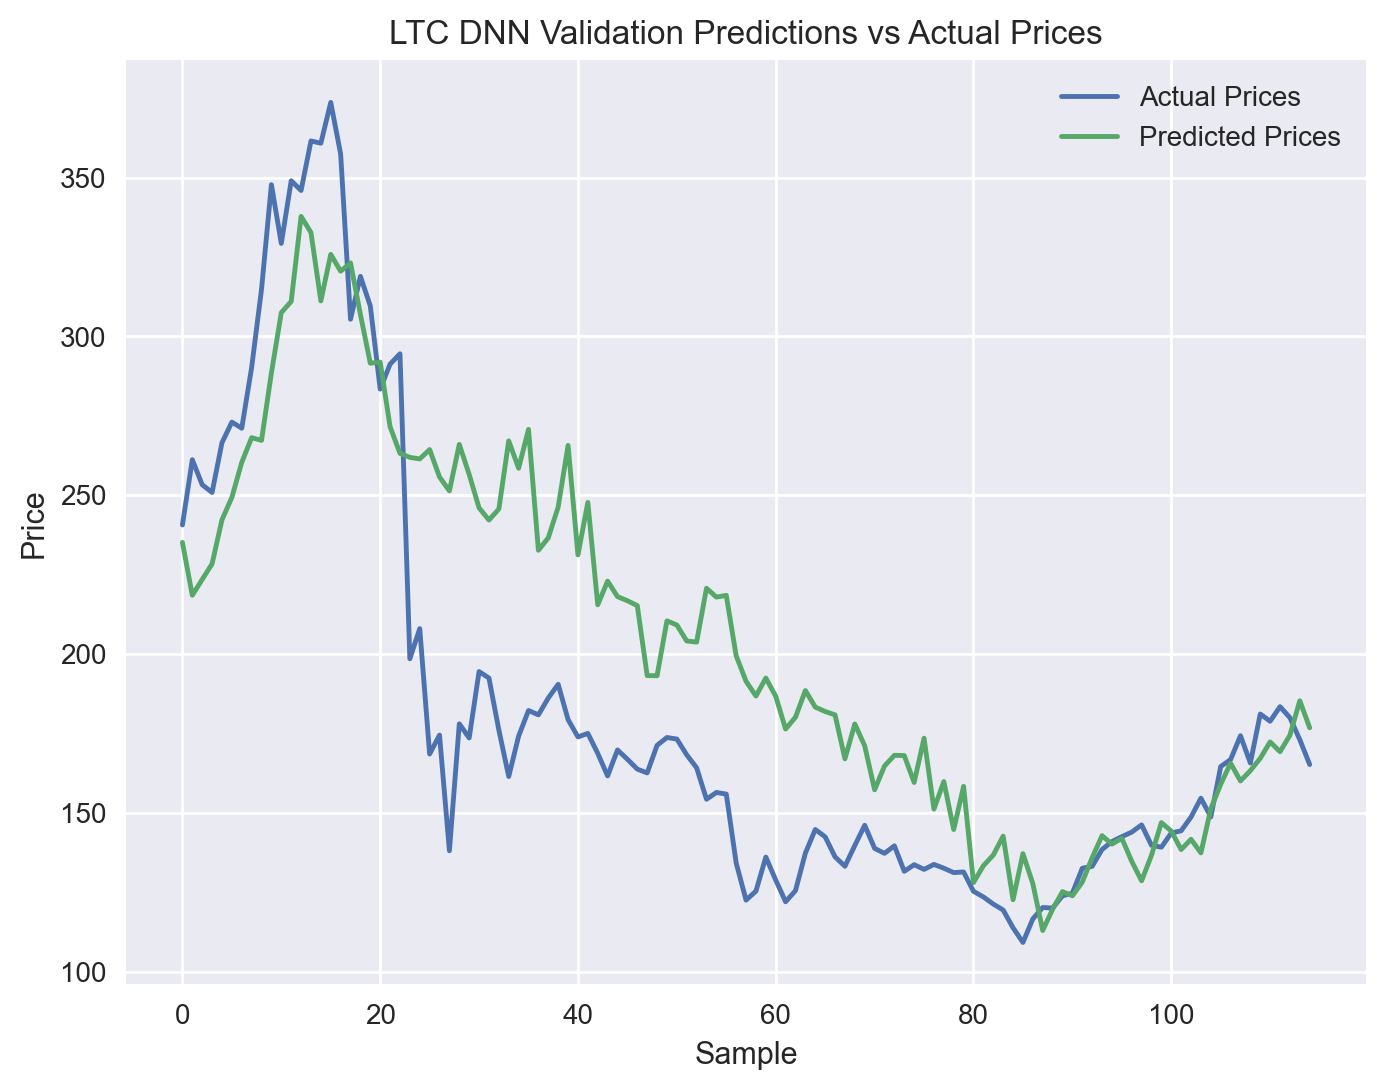

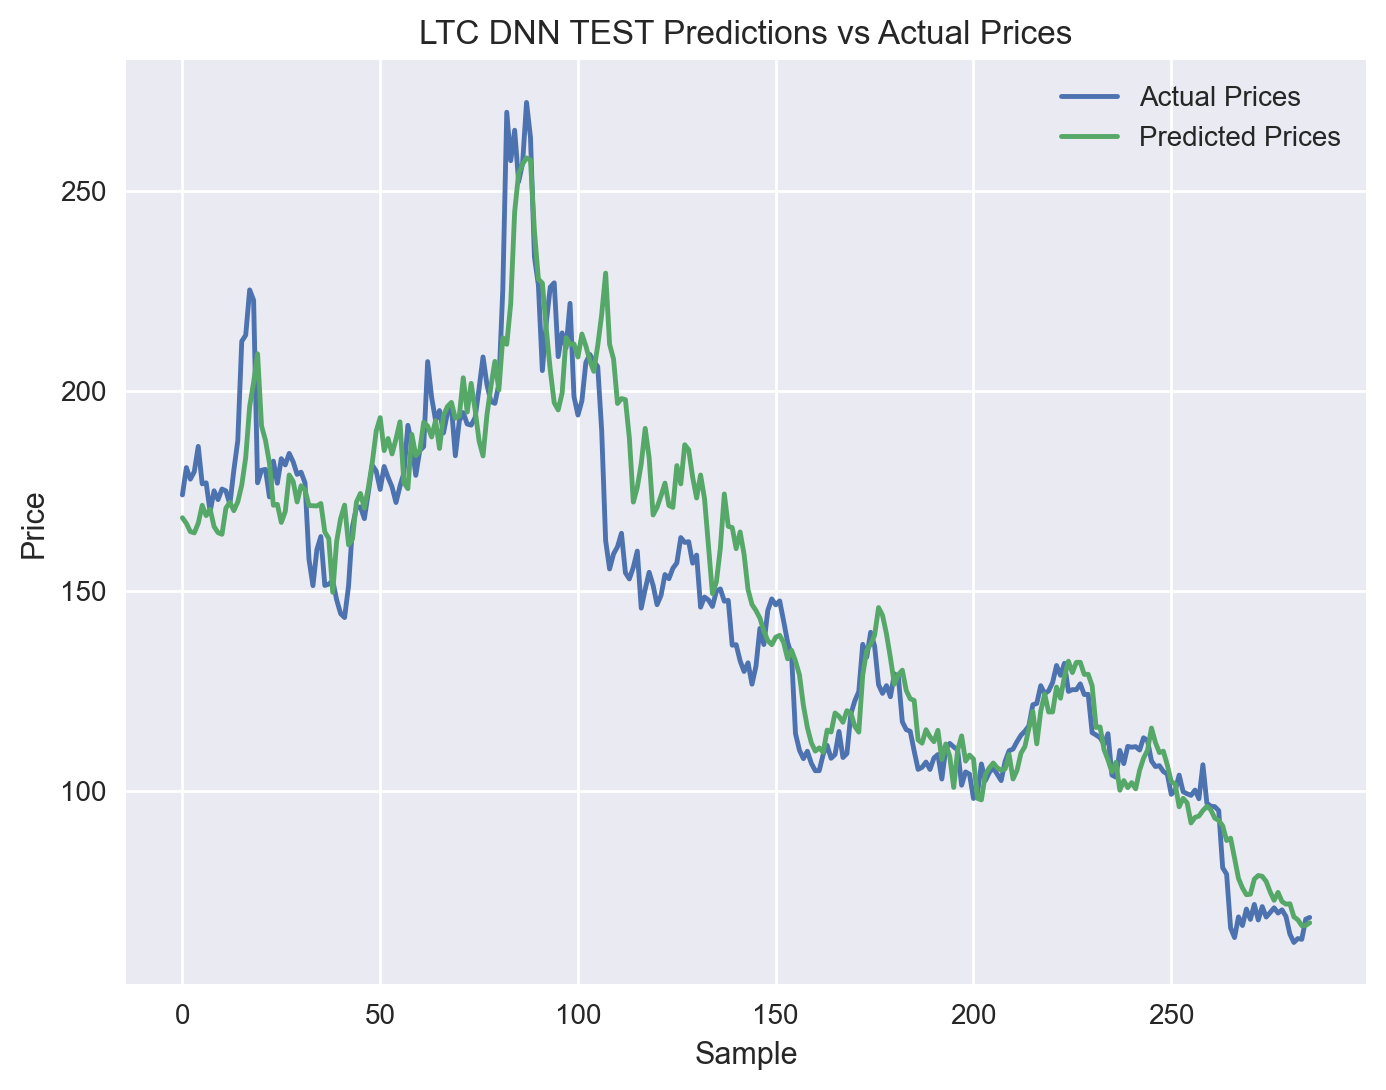

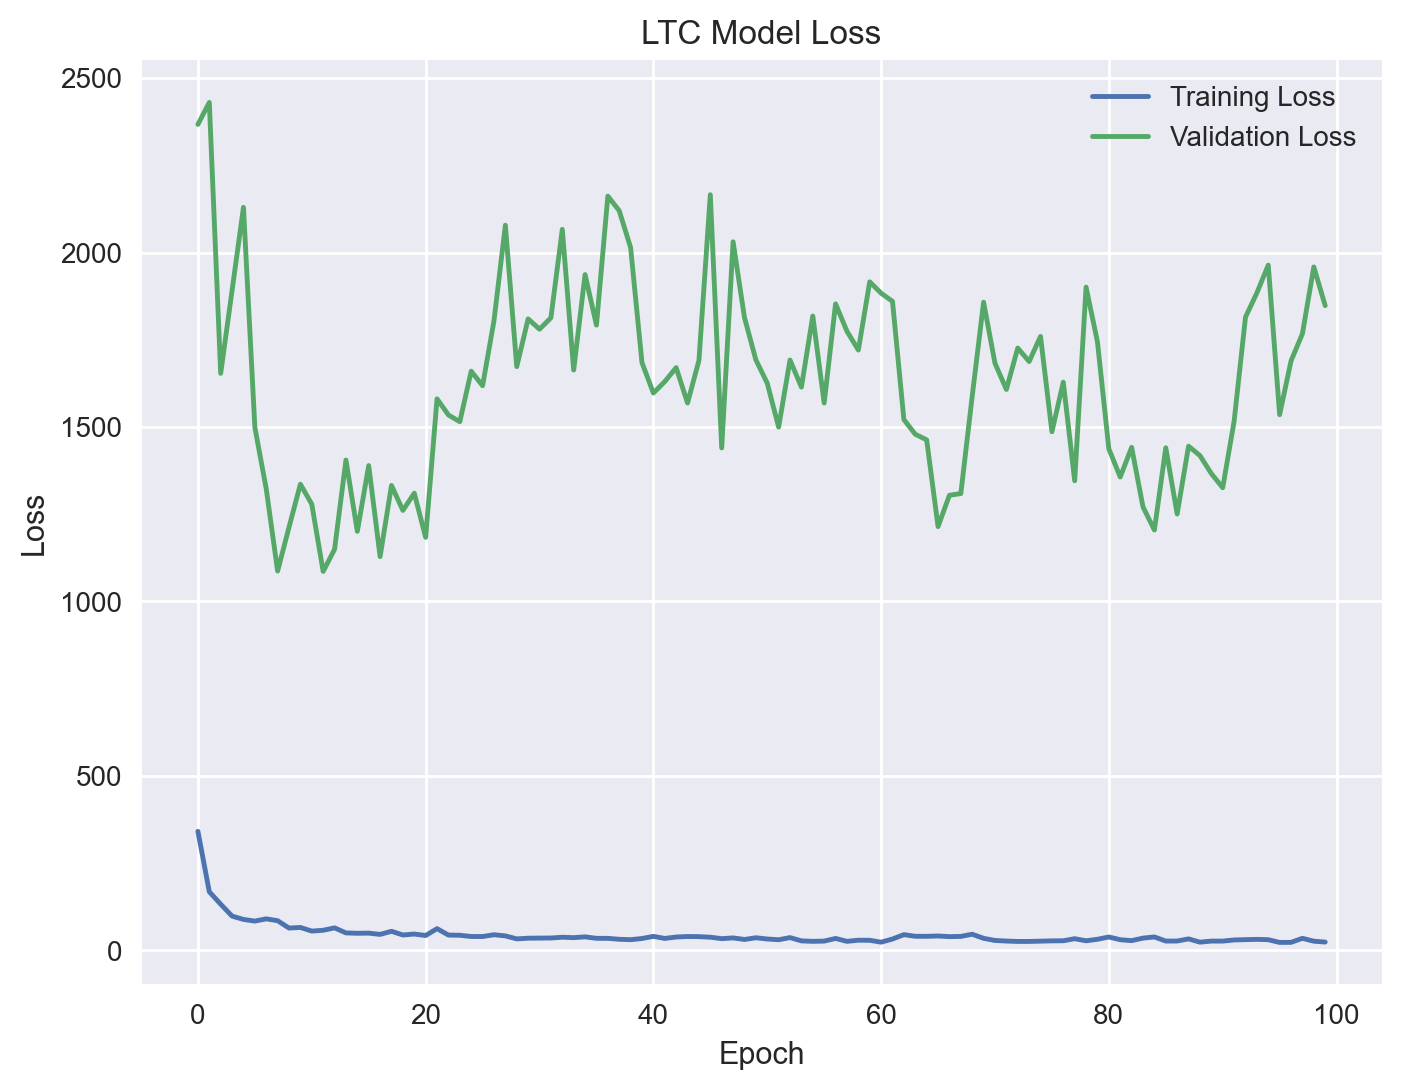

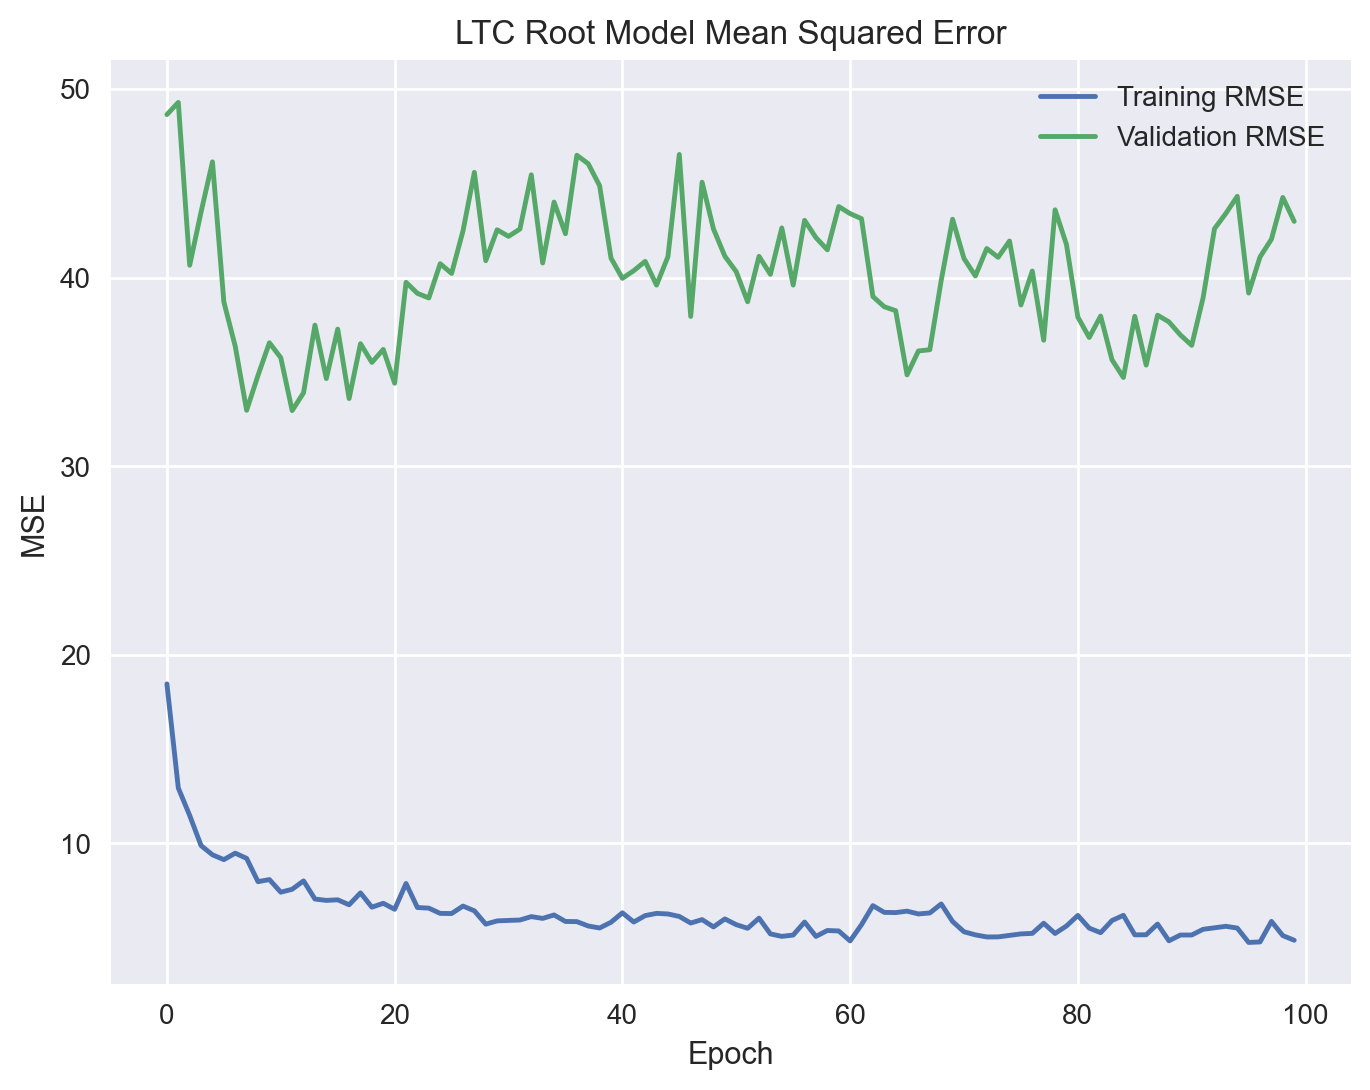

In [75]:
# Display the image
display(Image(filename='Images/btc_train_t1.png'))
display(Image(filename='Images/btc_validation_t1.png'))
display(Image(filename='Images/btc_test_t1.png'))
display(Image(filename='Images/btc_model_loss_t1.png'))
display(Image(filename='Images/btc_rmse_t1.png'))
display(Image(filename='Images/eth_train_t1.png'))
display(Image(filename='Images/eth_validation_t1.png'))
display(Image(filename='Images/eth_test_t1.png'))
display(Image(filename='Images/eth_model_loss_t1.png'))
display(Image(filename='Images/eth_rmse_t1.png'))
display(Image(filename='Images/ltc_train_t1.png'))
display(Image(filename='Images/ltc_validation_t1.png'))
display(Image(filename='Images/ltc_test_t1.png'))
display(Image(filename='Images/ltc_model_loss_t1.png'))
display(Image(filename='Images/ltc_rmse_t1.png'))

Looking at the results LTC is the outlier for our t+1 model. The learning curves have a large gap between training and validation, on the positive side the gap looks constant meaning the lack of overfitting. The price Forecasts for all three assets look much better when forecasting out only 1 day (looks promising).

The learning curves for BTC and ETH look overfit, especially BTC. It seems the model is adapting to the noise of the validation data as the gap between validation and training decreases. However, looking at the price forecasts done on the testing dataset, it looks quite good for BTC and ETH. 

## Walk Forward Analysis on ML: Finding optimal length of feature matrix

Below are the results of the walk forward analysis done on the number of days associated with creating the feature matrix. We see that a value of about 50 would be ideal as there is a cluster around the area. What this means is that to make a price prediction of t+5 days out for that asset (in this case BTC) the feature matrix will be taking the last 50 data points for BTC: Open, High, Low, Close, Returns, Volatility, RSI, and Momentum values.

The objective was to find the number of days from a list of [10,15,20,25,....90] in which Prediction Accuracy was maximized. A model with the parameters gathered from Keras-Tuner in the section above was used for all training and testing periods.

In [32]:
df_wf = pd.read_csv('btc_wf_pred_acc.csv')
df_wf = df_wf.drop('Unnamed: 0', axis=1)
df_wf

train_start   train_end  test_start    test_end  feature_val  \
0  2018-01-01  2018-07-20  2018-07-20  2019-02-05           20   
1  2018-07-20  2019-02-05  2019-02-05  2019-08-24           50   
2  2019-02-05  2019-08-24  2019-08-24  2020-03-11           85   
3  2019-08-24  2020-03-11  2020-03-11  2020-09-27           75   
4  2020-03-11  2020-09-27  2020-09-27  2021-04-15           50   
5  2020-09-27  2021-04-15  2021-04-15  2021-11-01           45   
6  2021-04-15  2021-11-01  2021-11-01  2022-05-20           20   

   Prediction Accuracy  
0             0.363636  
1             0.437500  
2             0.555556  
3             0.545455  
4             0.625000  
5             0.529412  
6             0.636364

(array([2., 0., 0., 1., 2., 0., 0., 0., 1., 1.]),
 array([20. , 26.5, 33. , 39.5, 46. , 52.5, 59. , 65.5, 72. , 78.5, 85. ]),
 <BarContainer object of 10 artists>)

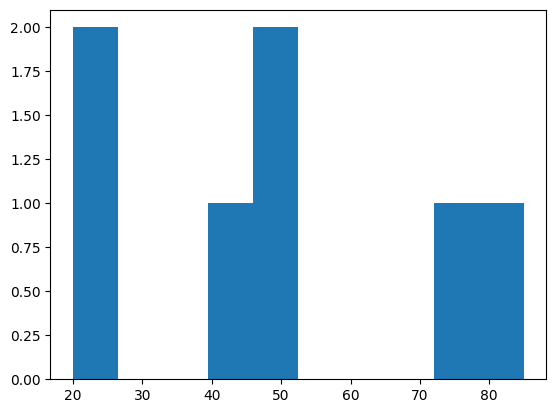

In [33]:
plt.hist(df_wf['feature_val'])

## The same walk forward analysis was also done on our t+1 model

In [53]:
df2 = pd.read_csv('btc_wf_pred_acc_t1.csv')
df2 = df2.drop('Unnamed: 0', axis=1)
df2

train_start   train_end  test_start    test_end  feature_val  \
0  2018-01-01  2018-07-20  2018-07-20  2019-02-05           45   
1  2018-07-20  2019-02-05  2019-02-05  2019-08-24           80   
2  2019-02-05  2019-08-24  2019-08-24  2020-03-11           55   
3  2019-08-24  2020-03-11  2020-03-11  2020-09-27           65   
4  2020-03-11  2020-09-27  2020-09-27  2021-04-15           65   
5  2020-09-27  2021-04-15  2021-04-15  2021-11-01           25   
6  2021-04-15  2021-11-01  2021-11-01  2022-05-20           70   

   Prediction Accuracy  
0             0.444444  
1             0.727273  
2             0.625000  
3             0.428571  
4             0.500000  
5             0.272727  
6             0.615385

(array([1., 0., 0., 1., 0., 1., 0., 2., 1., 1.]),
 array([25. , 30.5, 36. , 41.5, 47. , 52.5, 58. , 63.5, 69. , 74.5, 80. ]),
 <BarContainer object of 10 artists>)

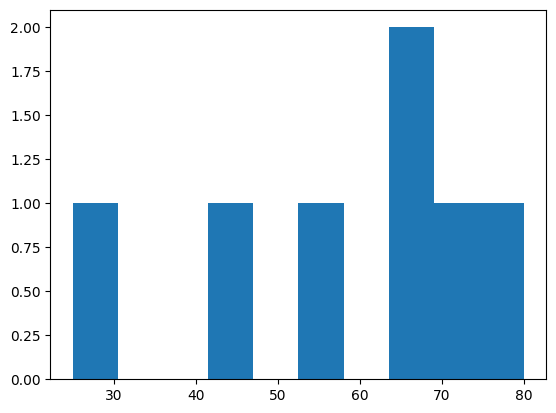

In [54]:
plt.hist(df2['feature_val'])

We find a value of 65 to be ideal as the cluster is near 65 which also occurs more often. This means for our asset price prediction of t+1 days out we use the last 65 days of feature data. 

# Backtesting Our Models (Cointegrated strat, t+1 ML, t+5 ML)

Now that we have our built models, we can backtest the cointegration strategy with and without Machine Learning signals. 

In [76]:
df_coint = pd.read_csv('coint.csv')
df_ml_5 = pd.read_csv('ML_t_5.csv')
df_ml_1 = pd.read_csv('ML_t1.csv')
df_coint.set_index('Unnamed: 0', inplace=True)
df_ml_5.set_index('Unnamed: 0', inplace=True)
df_ml_1.set_index('Unnamed: 0', inplace=True)

df_coint.index.name = 'metrics'
df_ml_5.index.name = 'metrics'
df_ml_1.index.name = 'metrics'

In [78]:
combined_df = pd.concat([df_coint, df_ml_1, df_ml_5], axis=1)
combined_df

0                    0  \
metrics                                                                     
method                                 Cointegration               ML t+1   
Total Net Profit                  -4854.538000000011    819.1064999999953   
Gross Profit                       18665.08749999999    8667.092599999994   
Gross Loss                       -23519.625500000002   -7847.986099999999   
Percent Profitable                 47.05882352941176   46.666666666666664   
Winning Trades                                    24                    7   
Losing Trades                                     24                    8   
Avg. Trade Net Profit             -95.18701960784335    54.60709999999969   
Avg. Winning Trade                 777.7119791666663    1238.156085714285   
Avg. Losing Trade                 -979.9843958333335   -980.9982624999999   
Ratio Avg. Win:Avg. Loss         -0.7935962883422608  -1.2621389181250309   
Largest Winning Trade              3463.064999999997            6895.0887   
Largest Losing Trade              -5471.971200000002              -2395.0   
Max. Consecutive Winning Trades                    4                    2   
Max. Consecutive Losing Trades                     5                    2   
Avg. Bars in Total Trades                        492                  225   
Avg. Bars in Winning Trades                      295                   77   
Avg. Bars in Losing Trades                       197                  148   
Max. Drawdown                     5975.0670000001555    4045.623900000006   

                                                   0  
metrics                                               
method                                        ML t+5  
Total Net Profit                  -9621.589100000005  
Gross Profit                      15437.244899999998  
Gross Loss                       -25058.834000000003  
Percent Profitable                 44.44444444444444  
Winning Trades                                    16  
Losing Trades                                     17  
Avg. Trade Net Profit            -267.26636388888903  
Avg. Winning Trade                 964.8278062499999  
Avg. Losing Trade                -1474.0490588235295  
Ratio Avg. Win:Avg. Loss           -0.65454253403211  
Largest Winning Trade                         2443.0  
Largest Losing Trade              -5076.947200000004  
Max. Consecutive Winning Trades                    4  
Max. Consecutive Losing Trades                     4  
Avg. Bars in Total Trades                        501  
Avg. Bars in Winning Trades                      303  
Avg. Bars in Losing Trades                       198  
Max. Drawdown                     10271.185200000065

# Results

We see that the best performing model was t+1 days ahead forecast, followed by the original cointegration strategy. The t+5 days ahead performed the worst. Maximum drawdown was also in that order.
This makes intuitive sense, as cryptocurrencies tend to be very volatile, a further looking forecast is most likely not going to provide a proper signal. This is also showcased on the forecasting plots when discussing building of each model. 

Overall signal based on ML does seem to have potential. The quality of these models will increase with more pricing data, this may translate better in the intraday context.

## Code
Backtest cointegration:  \
Backtest ML:   \
Walkforward ML:  